# Detection of pulmonary infections with Deep Learning (CT-scans)

In [1]:
import os
import math
import random
import pickle

from zipfile import ZipFile

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.random import set_seed
from tensorflow import keras
from tensorflow.keras import layers, models

from sklearn.metrics import confusion_matrix, classification_report

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_DIR = 'drive/MyDrive/COVID_crop'
categories = ['normal', 'malade']

In [ ]:
print(f'Number of normal samples : {len(os.listdir(os.path.join(DATA_DIR, categories[0])))}')
print(f'Number of sick samples : {len(os.listdir(os.path.join(DATA_DIR, categories[1])))}')

Number of normal samples : 1078
Number of sick samples : 1544


## Time step distribution

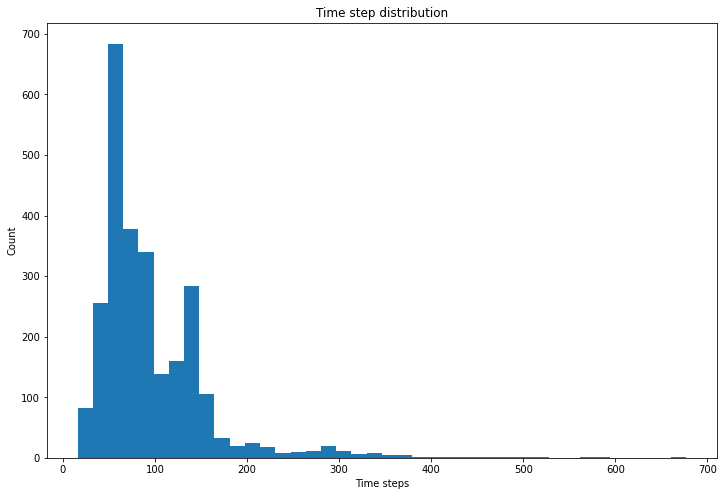

In [ ]:
time_steps = []
for category in categories:
  path = os.path.join(DATA_DIR, category)
  for sample in os.listdir(path):
    time_steps.append(len(os.listdir(os.path.join(path, sample))))

plt.figure(figsize=(12,8))
plt.hist(time_steps, bins = 40)
plt.title('Time step distribution')
plt.xlabel('Time steps')
plt.ylabel('Count')
plt.show()
max_time_steps = np.max(time_steps)

## Check the numbers of samples which have a time step less or equal to 95

In [ ]:
n_normal = 0
path = os.path.join(DATA_DIR, 'normal')
for sample in os.listdir(path):
  if len(os.listdir(os.path.join(path, sample))) < 95:
    n_normal += 1
print(n_normal)

812


In [ ]:
n_malade = 0
path = os.path.join(DATA_DIR, 'malade')
for sample in os.listdir(path):
  if len(os.listdir(os.path.join(path, sample))) < 95:
    n_malade += 1
print(n_malade)

865


812 normal samples and 865 sick samples have a time step less or equal to 95.

Therefore, if we want to take 1600 (balanced) samples, we can pick those with a time step < 95.

## Data generation (store in files with Pickle)

In [ ]:
# Create batches of data, stored in Pickle files

def create_dataset(n_data, batch_size, set_type, normal_index, sick_index):
    n_iter = n_data//batch_size
    #Store the index to create disjoint sets (train, val, test)
    i_normal, i_sick = normal_index, sick_index
    #For each batch
    for k in range(n_iter):
        #Choose the samples which have time steps < 95 (we store their path and their time steps)
        time_steps = {}
        for category in categories:
            path = os.path.join(DATA_DIR, category)
            j = 0 
            while j < batch_size//2:
                if category == 'normal':
                    sample = os.listdir(path)[i_normal]
                    i_normal += 1
                else:
                    sample = os.listdir(path)[i_sick]
                    i_sick += 1
                if sample != '.DS_Store':
                    length = len(os.listdir(os.path.join(path, sample)))
                    if length < 95: 
                        time_steps[os.path.join(path, sample)] = length
                        j += 1
                        
        #Create the batches (X and y)
        max_time_steps = np.max(list(time_steps.values()))
        print(max_time_steps)
        X = np.zeros((len(time_steps), max_time_steps, 128*128), dtype = 'float16')
        y = np.zeros((len(time_steps), 1), dtype = 'bool')
        for i, sample in enumerate(time_steps.keys()):
            if 'normal' in sample:
                y[i] = 0
            else:
                y[i] = 1
            for j, img  in enumerate(os.listdir(sample)):
                X[i, j, :] = cv2.imread(os.path.join(sample, img), cv2.IMREAD_GRAYSCALE).ravel()[:]
        X /= 255
        print(np.unique(y, return_counts = True))
  
        #Store with Pickle
        output = open(f'dataset_batches/{set_type}/batch{k}.pickle', 'wb')
        pickle.dump([X, y], output)
        output.close()
    print(f'i_normal : {i_normal}')
    print(f'i_sick : {i_sick}')

In [ ]:
#create_dataset(1200, 8, 'train', 0, 0)
#create_dataset(200, 8, 'val', 803, 1067)
#create_dataset(200, 8, 'test', 930, 1242)

In [ ]:
'''f = 'drive/MyDrive/test.zip'

with ZipFile(f, 'r') as zip:
  zip.extractall('drive/MyDrive')'''

## Set random seeds

In [2]:
set_seed(42)
np.random.seed(42)

## Creation of a generator (to avoid memory issues)

### Generator class

*Params* :

  - set_type : the path to the directory which contains the batches

  - is_img : if True, the format of features will be image format, namely (128, 128). Else, it will be a vector of dimensions (128*128, 1).

In [3]:
class DataGenerator(keras.utils.Sequence):

  def __init__(self, path, is_img = False):
          self.path = path
          self.is_img = is_img

  def __len__(self):
      return len(os.listdir(self.path))

  def __getitem__(self, idx):
    input = open(os.path.join(self.path, f'batch{idx}.pickle'), 'rb')
    X, y = pickle.load(input)
    input.close()
    if self.is_img:
      X = X.reshape((X.shape[0], X.shape[1], 128, 128, 1))
    return X, y

In [4]:
train_gen = DataGenerator('drive/MyDrive/train', is_img = True)
val_gen = DataGenerator('drive/MyDrive/val', is_img = True)
test_gen = DataGenerator('drive/MyDrive/test', is_img = True)

In [ ]:
print(train_gen.__len__())
print(val_gen.__len__())
print(test_gen.__len__())

150
25
25


## Metrics

**Evaluation** function trains the model and computes different metrics : 

- confusion matrix
- classification report (recall, precision, f1)
- learning curves (loss and accuracy through epochs)

In [ ]:
true_labels = []
n_batch = 0
for _ , y in test_gen:
  if n_batch < 25:
    for y_i in y:
      true_labels.append(int(y_i))
    n_batch += 1

print(len(true_labels))

200


In [ ]:
def evaluation(model_name, model, patience):
    #Fit the model to the data
    history =  model.fit(train_gen,
                         steps_per_epoch=None,
                         epochs=50,
                         validation_data=val_gen,
                         validation_steps=None,
                         callbacks = keras.callbacks.EarlyStopping(monitor = 'val_accuracy', 
                                                                   patience = patience,
                                                                   restore_best_weights = True))
    
    #Accuracy on test set
    print("\n Accuracy on test set :", model.evaluate(test_gen)[1], "\n \n")

    pred = model.predict(test_gen)
    y_pred = [int(round(float(i))) for i in pred]

    #Confusion matrix
    cm = confusion_matrix(true_labels, y_pred)
    cm_sum = cm.sum(axis=1)
    c_matrix = cm/cm_sum.reshape((cm_sum.shape[0], 1))
    plt.figure(figsize=(12,8))
    print(sns.heatmap(c_matrix, annot = True, fmt = '.2f', cmap = plt.cm.Blues))
    plt.show()
    #Metrics
    print("\n\nClassification report :\n\n", classification_report(true_labels, y_pred))
    
    #Learning curves 
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12,8))
    plt.plot(acc,label='Training acc')
    plt.plot(val_acc, label='Validation acc')
    plt.title(f'{model_name} : Accuracy')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    

    plt.figure(figsize=(12,8))
    plt.plot(loss, label='Training loss')
    plt.plot(val_loss, label='Validation loss')
    plt.title(f'{model_name} : Loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.show()

## Learning rate schedule 

In [ ]:
initial_learning_rate = 0.001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

## LSTM

### 1-layer LSTM 

In [ ]:
model = models.Sequential()

model.add(layers.Masking(mask_value = 0.0, input_shape = (None, 128*128)))

model.add(layers.LSTM(units = 32, 
                      activation ='tanh', 
                      recurrent_activation='sigmoid', 
                      return_sequences=False))

model.add(layers.Dropout(0.4))

model.add(layers.Dense(16, activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [ ]:
model.compile(optimizer = keras.optimizers.Adam(lr_schedule), loss = 'binary_crossentropy', metrics = 'accuracy')

Epoch 1/50
150/150 [==============================] - 35s 212ms/step - loss: 0.7016 - accuracy: 0.5327 - val_loss: 0.6238 - val_accuracy: 0.7150
Epoch 2/50
150/150 [==============================] - 30s 200ms/step - loss: 0.6153 - accuracy: 0.6896 - val_loss: 0.5406 - val_accuracy: 0.7600
Epoch 3/50
150/150 [==============================] - 30s 200ms/step - loss: 0.5500 - accuracy: 0.7363 - val_loss: 0.4983 - val_accuracy: 0.7950
Epoch 4/50
150/150 [==============================] - 30s 200ms/step - loss: 0.4887 - accuracy: 0.7792 - val_loss: 0.4169 - val_accuracy: 0.8300
Epoch 5/50
150/150 [==============================] - 30s 200ms/step - loss: 0.4375 - accuracy: 0.7852 - val_loss: 0.3897 - val_accuracy: 0.8350
Epoch 6/50
150/150 [==============================] - 30s 200ms/step - loss: 0.3711 - accuracy: 0.8482 - val_loss: 0.3693 - val_accuracy: 0.8300
Epoch 7/50
150/150 [==============================] - 30s 200ms/step - loss: 0.3443 - accuracy: 0.8707 - val_loss: 0.3518 - val_ac

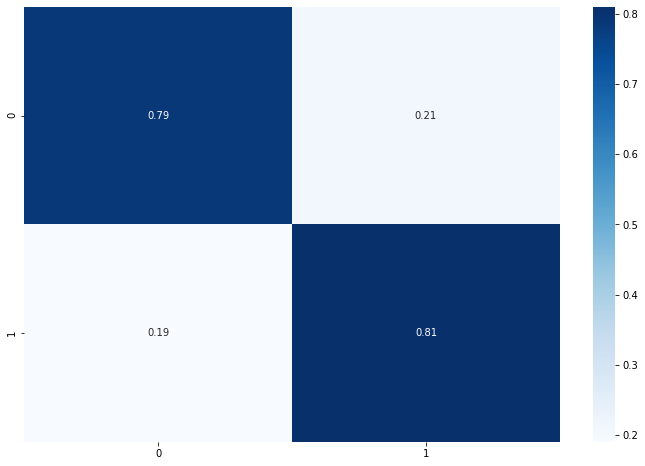



Classification report :

               precision    recall  f1-score   support

           0       0.81      0.79      0.80       100
           1       0.79      0.81      0.80       100

    accuracy                           0.80       200
   macro avg       0.80      0.80      0.80       200
weighted avg       0.80      0.80      0.80       200



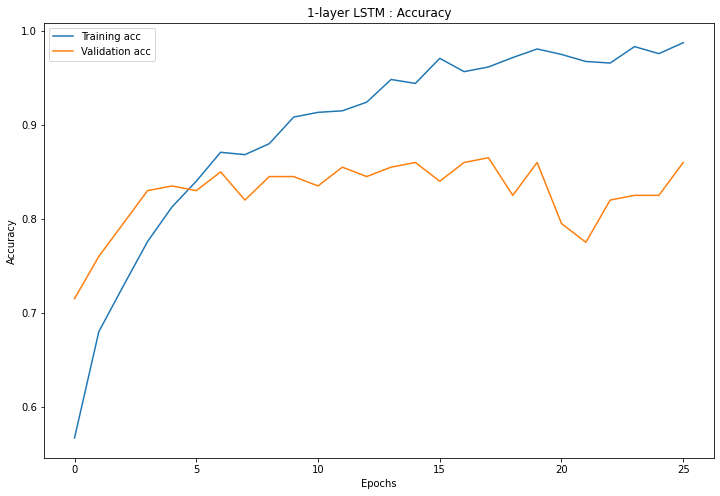

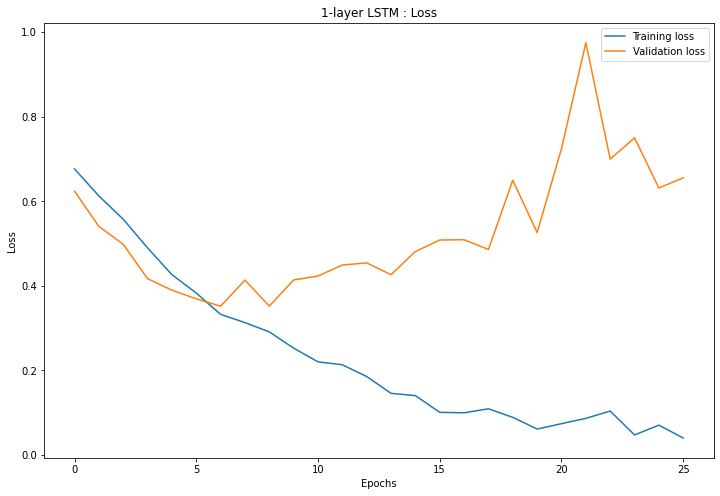

In [ ]:
evaluation('1-layer LSTM', model, patience = 8)

In [ ]:
model.save('drive/MyDrive/modeles/1_LSTM_32.h5')

### 2-layer LSTM 

In [ ]:
model = models.Sequential()

model.add(layers.Masking(mask_value = 0.0, input_shape = (None, 128*128)))

model.add(layers.LSTM(units = 32, 
                      activation ='tanh', 
                      recurrent_activation='sigmoid', 
                      return_sequences=True))

model.add(layers.Dropout(0.5))

model.add(layers.LSTM(units = 16, 
                      activation ='tanh', 
                      recurrent_activation='sigmoid', 
                      return_sequences=False))

model.add(layers.Dropout(0.3))

model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [ ]:
model.compile(optimizer = keras.optimizers.Adam(lr_schedule), loss = 'binary_crossentropy', metrics = 'accuracy')

Epoch 1/50
150/150 [==============================] - 61s 362ms/step - loss: 0.6893 - accuracy: 0.5383 - val_loss: 0.5976 - val_accuracy: 0.7500
Epoch 2/50
150/150 [==============================] - 53s 350ms/step - loss: 0.5937 - accuracy: 0.7072 - val_loss: 0.5027 - val_accuracy: 0.7600
Epoch 3/50
150/150 [==============================] - 53s 350ms/step - loss: 0.4709 - accuracy: 0.8081 - val_loss: 0.4691 - val_accuracy: 0.8000
Epoch 4/50
150/150 [==============================] - 53s 352ms/step - loss: 0.4194 - accuracy: 0.8365 - val_loss: 0.3788 - val_accuracy: 0.8700
Epoch 5/50
150/150 [==============================] - 52s 346ms/step - loss: 0.3424 - accuracy: 0.8752 - val_loss: 0.4471 - val_accuracy: 0.8500
Epoch 6/50
150/150 [==============================] - 52s 344ms/step - loss: 0.3548 - accuracy: 0.8576 - val_loss: 0.3368 - val_accuracy: 0.8750
Epoch 7/50
150/150 [==============================] - 52s 348ms/step - loss: 0.2907 - accuracy: 0.8865 - val_loss: 0.4581 - val_ac

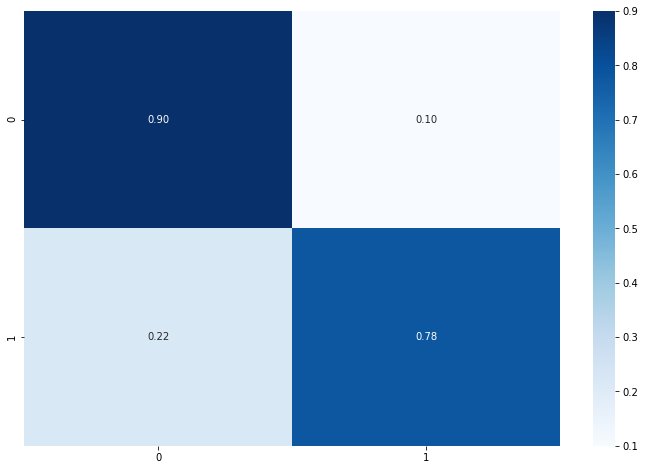



Classification report :

               precision    recall  f1-score   support

           0       0.80      0.90      0.85       100
           1       0.89      0.78      0.83       100

    accuracy                           0.84       200
   macro avg       0.84      0.84      0.84       200
weighted avg       0.84      0.84      0.84       200



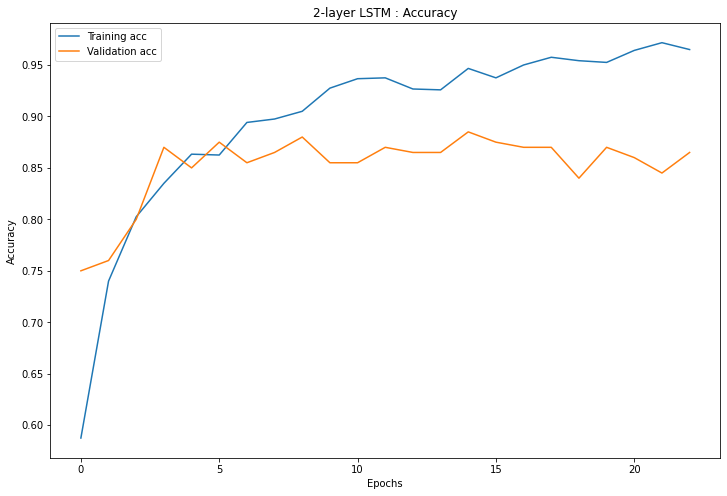

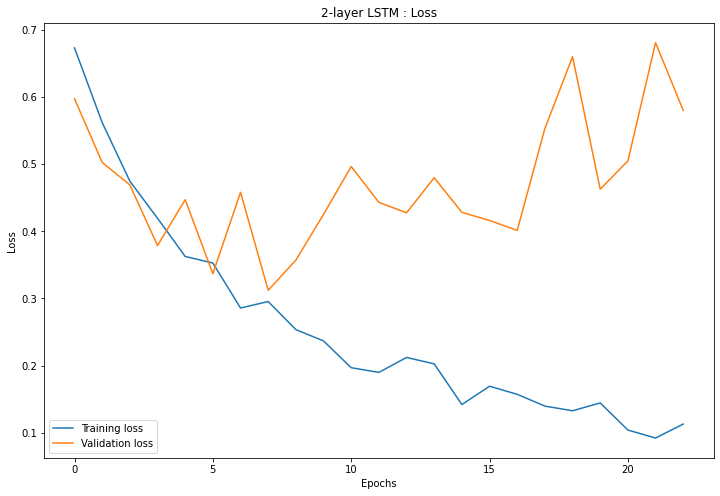

In [ ]:
evaluation('2-layer LSTM', model, patience = 8)

In [ ]:
model.save('drive/MyDrive/modeles/2_LSTM_32_16.h5')

## Notes : 

- Quite good performances seeing that there is no convolution
- But important overfitting
- Performance isn't really robust to the data

## Conv LSTM

In [ ]:
model = models.Sequential()

model.add(layers.ConvLSTM2D(filters=15, kernel_size=(5, 5), padding="valid", return_sequences=True, input_shape = (None, 128, 128, 1)))
model.add(layers.Dropout(0.4))
model.add(layers.BatchNormalization())
model.add(layers.GlobalMaxPooling3D())

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_3 (ConvLSTM2D)  (None, None, 124, 124, 15 24060     
_________________________________________________________________
dropout_32 (Dropout)         (None, None, 124, 124, 15 0         
_________________________________________________________________
batch_normalization_3 (Batch (None, None, 124, 124, 15 60        
_________________________________________________________________
global_max_pooling3d_3 (Glob (None, 15)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 64)                1024      
_________________________________________________________________
dropout_33 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 32)              

In [ ]:
model.compile(optimizer= keras.optimizers.Adam(lr_schedule), loss = 'binary_crossentropy', metrics = 'accuracy')

Epoch 1/50
150/150 [==============================] - 116s 757ms/step - loss: 0.8086 - accuracy: 0.5163 - val_loss: 0.6892 - val_accuracy: 0.5000
Epoch 2/50
150/150 [==============================] - 113s 753ms/step - loss: 0.5678 - accuracy: 0.7065 - val_loss: 0.6609 - val_accuracy: 0.5300
Epoch 3/50
150/150 [==============================] - 113s 754ms/step - loss: 0.4118 - accuracy: 0.7904 - val_loss: 0.5015 - val_accuracy: 0.7950
Epoch 4/50
150/150 [==============================] - 113s 753ms/step - loss: 0.3550 - accuracy: 0.8451 - val_loss: 0.3932 - val_accuracy: 0.8650
Epoch 5/50
150/150 [==============================] - 113s 753ms/step - loss: 0.3244 - accuracy: 0.8713 - val_loss: 0.2751 - val_accuracy: 0.9150
Epoch 6/50
150/150 [==============================] - 113s 755ms/step - loss: 0.2633 - accuracy: 0.8960 - val_loss: 0.2686 - val_accuracy: 0.9050
Epoch 7/50
150/150 [==============================] - 113s 754ms/step - loss: 0.2437 - accuracy: 0.9114 - val_loss: 0.2432 -

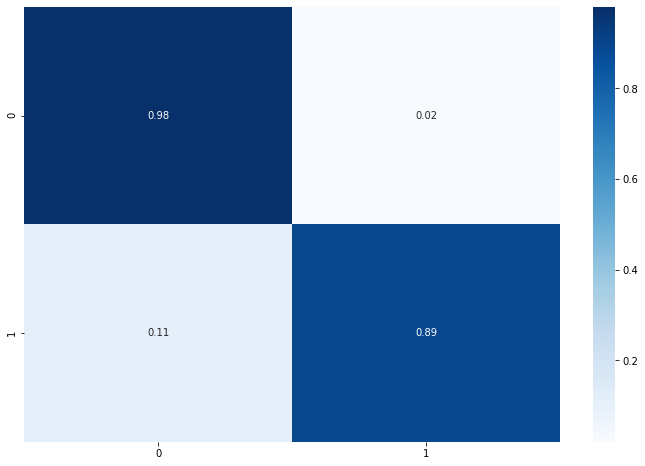



Classification report :

               precision    recall  f1-score   support

           0       0.90      0.98      0.94       100
           1       0.98      0.89      0.93       100

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.93       200
weighted avg       0.94      0.94      0.93       200



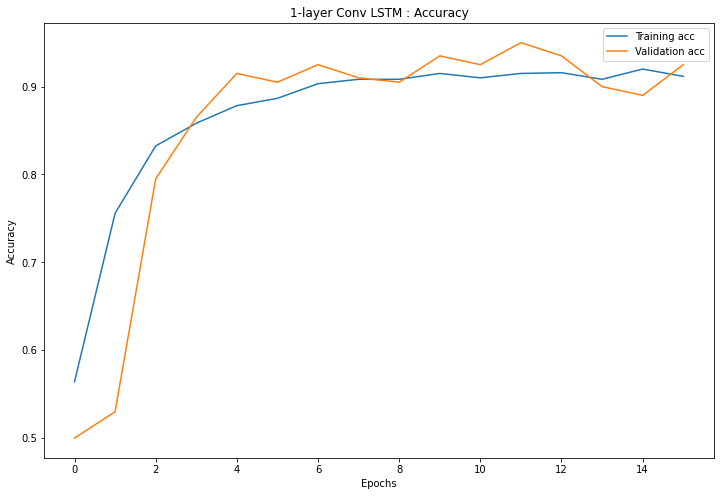

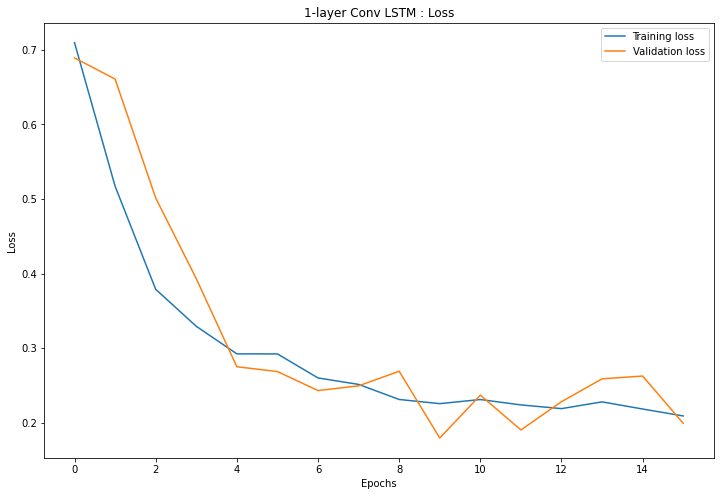

In [ ]:
evaluation('1-layer Conv LSTM', model, patience = 4)

In [ ]:
model.save('drive/MyDrive/modeles/1_convLSTM_15.h5')

## Notes :

- High performance

- No overfitting

- Robust to the dataset (0.95 val, 0.935 test)

- It may have better performance with a higher number of filters (but impossible to run with Colab)

## CNN 2D + LSTM

In [ ]:
model = models.Sequential()

model.add(layers.TimeDistributed(layers.Conv2D(32, (5,5), activation = 'relu'), input_shape = (None, 128, 128, 1)))
model.add(layers.TimeDistributed(layers.MaxPool2D(pool_size = (2,2))))
model.add(layers.TimeDistributed(layers.BatchNormalization()))

model.add(layers.TimeDistributed(layers.Conv2D(32, (5,5), activation = 'relu')))
model.add(layers.TimeDistributed(layers.MaxPool2D(pool_size = (2,2))))
model.add(layers.TimeDistributed(layers.BatchNormalization()))

model.add(layers.TimeDistributed(layers.Conv2D(32, (5,5), activation = 'relu')))
model.add(layers.TimeDistributed(layers.MaxPool2D(pool_size = (2,2))))
model.add(layers.TimeDistributed(layers.BatchNormalization()))
model.add(layers.TimeDistributed(layers.Flatten()))

model.add(layers.LSTM(units = 32, 
                      activation ='tanh', 
                      recurrent_activation='sigmoid', 
                      return_sequences=True))

model.add(layers.LSTM(units = 32, 
                      activation ='tanh', 
                      recurrent_activation='sigmoid', 
                      return_sequences=True))

model.add(layers.GlobalMaxPooling1D())

model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [ ]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_163 (TimeDi (None, None, 124, 124, 32 832       
_________________________________________________________________
time_distributed_164 (TimeDi (None, None, 62, 62, 32)  0         
_________________________________________________________________
time_distributed_165 (TimeDi (None, None, 62, 62, 32)  128       
_________________________________________________________________
time_distributed_166 (TimeDi (None, None, 58, 58, 32)  25632     
_________________________________________________________________
time_distributed_167 (TimeDi (None, None, 29, 29, 32)  0         
_________________________________________________________________
time_distributed_168 (TimeDi (None, None, 29, 29, 32)  128       
_________________________________________________________________
time_distributed_169 (TimeDi (None, None, 25, 25, 32)

In [ ]:
model.compile(optimizer= keras.optimizers.Adam(lr_schedule), loss = 'binary_crossentropy', metrics = 'accuracy')

Epoch 1/50
150/150 [==============================] - 31s 176ms/step - loss: 0.5793 - accuracy: 0.7174 - val_loss: 0.8794 - val_accuracy: 0.5000
Epoch 2/50
150/150 [==============================] - 25s 168ms/step - loss: 0.2924 - accuracy: 0.8843 - val_loss: 1.3528 - val_accuracy: 0.5050
Epoch 3/50
150/150 [==============================] - 25s 168ms/step - loss: 0.2472 - accuracy: 0.8998 - val_loss: 1.2412 - val_accuracy: 0.3050
Epoch 4/50
150/150 [==============================] - 25s 167ms/step - loss: 0.1737 - accuracy: 0.9332 - val_loss: 0.8513 - val_accuracy: 0.5650
Epoch 5/50
150/150 [==============================] - 25s 168ms/step - loss: 0.1767 - accuracy: 0.9389 - val_loss: 1.2025 - val_accuracy: 0.4900
Epoch 6/50
150/150 [==============================] - 25s 167ms/step - loss: 0.1701 - accuracy: 0.9328 - val_loss: 0.4667 - val_accuracy: 0.7850
Epoch 7/50
150/150 [==============================] - 25s 167ms/step - loss: 0.1830 - accuracy: 0.9167 - val_loss: 0.4629 - val_ac

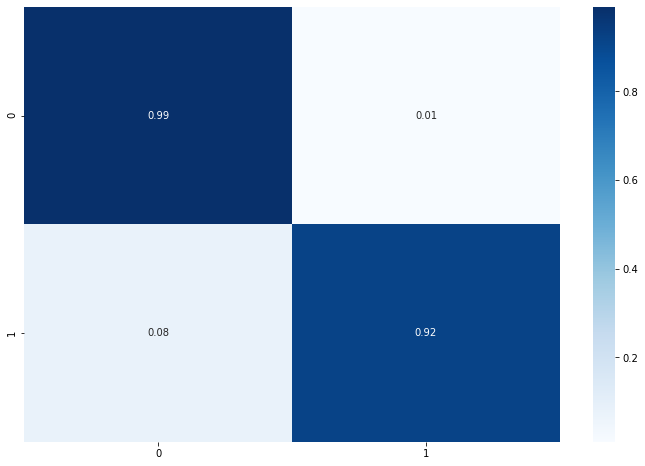



Classification report :

               precision    recall  f1-score   support

           0       0.93      0.99      0.96       100
           1       0.99      0.92      0.95       100

    accuracy                           0.95       200
   macro avg       0.96      0.96      0.95       200
weighted avg       0.96      0.95      0.95       200



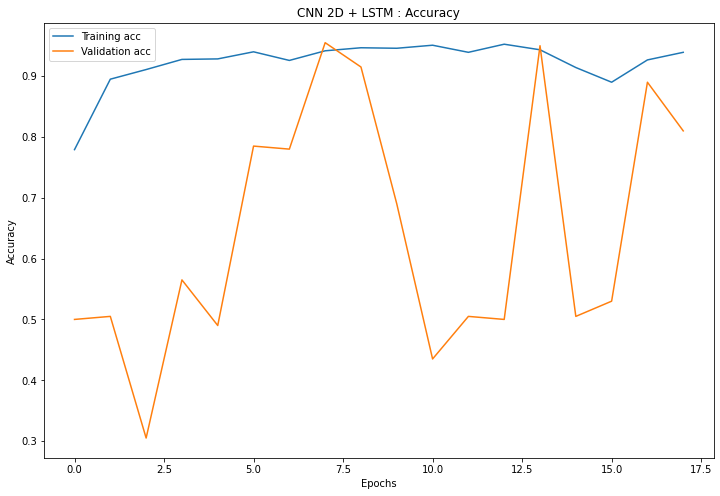

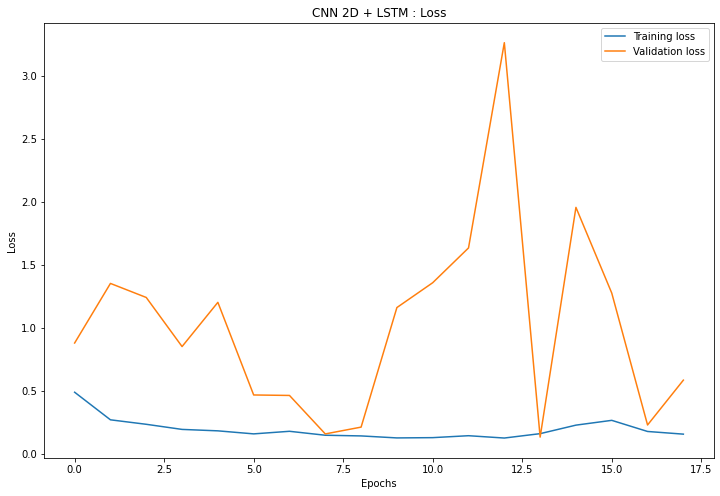

In [ ]:
evaluation('CNN 2D + LSTM', model, patience = 10)

In [ ]:
model.save('drive/MyDrive/modeles/3_Conv_2_LSTM.h5')

In [ ]:
model = models.Sequential()

model.add(layers.TimeDistributed(layers.Conv2D(32, (5,5), activation = 'relu'), input_shape = (None, 128, 128, 1)))
model.add(layers.TimeDistributed(layers.MaxPool2D(pool_size = (2,2))))
model.add(layers.TimeDistributed(layers.BatchNormalization()))

model.add(layers.TimeDistributed(layers.Conv2D(32, (5,5), activation = 'relu')))
model.add(layers.TimeDistributed(layers.MaxPool2D(pool_size = (2,2))))
model.add(layers.TimeDistributed(layers.BatchNormalization()))

model.add(layers.TimeDistributed(layers.Conv2D(32, (5,5), activation = 'relu')))
model.add(layers.TimeDistributed(layers.MaxPool2D(pool_size = (2,2))))
model.add(layers.TimeDistributed(layers.BatchNormalization()))
model.add(layers.TimeDistributed(layers.Flatten()))

model.add(layers.LSTM(units = 64, 
                      activation ='tanh', 
                      recurrent_activation='sigmoid', 
                      return_sequences=True))

model.add(layers.Dropout(0.3))

model.add(layers.LSTM(units = 32, 
                      activation ='tanh', 
                      recurrent_activation='sigmoid', 
                      return_sequences=True))

model.add(layers.Dropout(0.2))

model.add(layers.GlobalMaxPooling1D())

model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [ ]:
model.compile(optimizer= keras.optimizers.Adam(lr_schedule), loss = 'binary_crossentropy', metrics = 'accuracy')

Epoch 1/50
150/150 [==============================] - 31s 175ms/step - loss: 0.6317 - accuracy: 0.6274 - val_loss: 0.7543 - val_accuracy: 0.5000
Epoch 2/50
150/150 [==============================] - 25s 168ms/step - loss: 0.4053 - accuracy: 0.8309 - val_loss: 1.3927 - val_accuracy: 0.5200
Epoch 3/50
150/150 [==============================] - 25s 167ms/step - loss: 0.3040 - accuracy: 0.8920 - val_loss: 1.0648 - val_accuracy: 0.5350
Epoch 4/50
150/150 [==============================] - 25s 168ms/step - loss: 0.2161 - accuracy: 0.9132 - val_loss: 0.6165 - val_accuracy: 0.7200
Epoch 5/50
150/150 [==============================] - 25s 167ms/step - loss: 0.1785 - accuracy: 0.9349 - val_loss: 1.1148 - val_accuracy: 0.5050
Epoch 6/50
150/150 [==============================] - 25s 167ms/step - loss: 0.1981 - accuracy: 0.9258 - val_loss: 0.3667 - val_accuracy: 0.8250
Epoch 7/50
150/150 [==============================] - 25s 168ms/step - loss: 0.1944 - accuracy: 0.9286 - val_loss: 0.8298 - val_ac

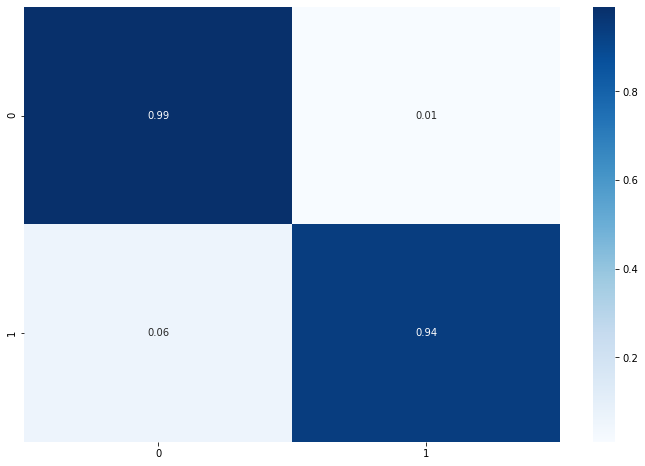



Classification report :

               precision    recall  f1-score   support

           0       0.94      0.99      0.97       100
           1       0.99      0.94      0.96       100

    accuracy                           0.96       200
   macro avg       0.97      0.96      0.96       200
weighted avg       0.97      0.96      0.96       200



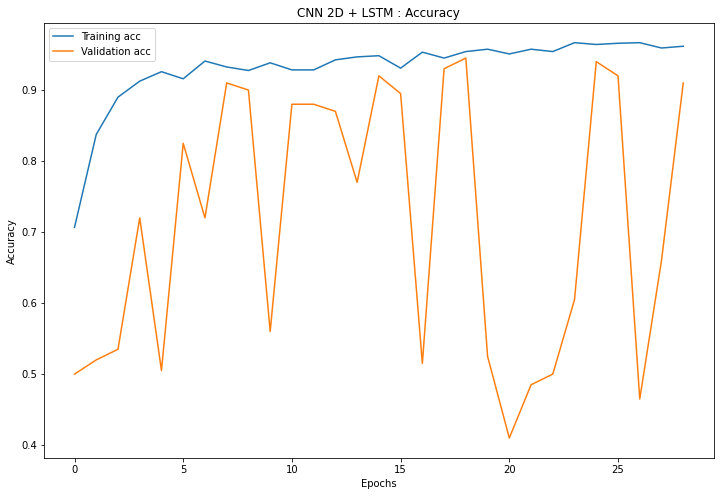

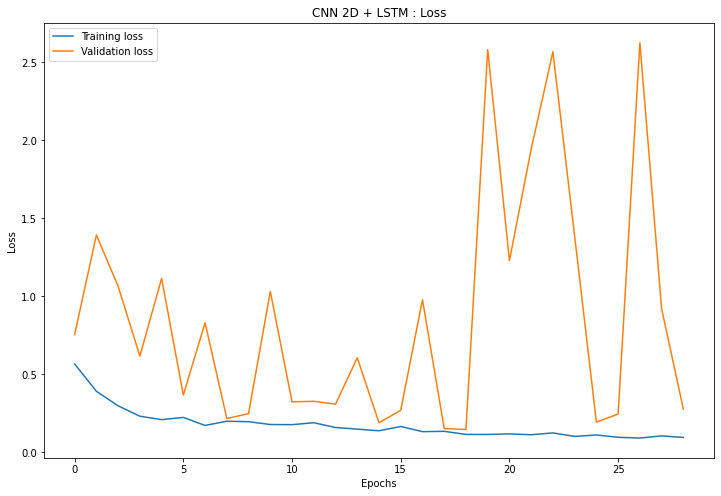

In [ ]:
evaluation('CNN 2D + LSTM', model, patience = 10)

## Notes 

- High performance

- Unstable through epochs

- But robust to the data (0.955 for both val and test sets)

## LSTM + CNN 2D

In [ ]:
model = models.Sequential()

model.add(layers.Masking(mask_value = 0.0, input_shape = (None, 128*128)))

model.add(layers.LSTM(units = 32, 
                      activation ='tanh', 
                      recurrent_activation='sigmoid', 
                      return_sequences=True, input_shape = (None, 128*128)))

layers.Dropout(0.2)

model.add(layers.LSTM(units = 121, 
                      activation ='tanh', 
                      recurrent_activation='sigmoid', 
                      return_sequences=False))

layers.Dropout(0.2)

model.add(layers.Reshape((11, 11, 1)))

model.add(layers.Conv2D(32, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(32, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())

model.add(layers.Dense(64, activation = 'relu'))
layers.Dropout(0.2)
model.add(layers.Dense(32, activation = 'relu'))
layers.Dropout(0.2)
model.add(layers.Dense(1, activation = 'sigmoid'))

In [ ]:
model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, None, 16384)       0         
_________________________________________________________________
lstm_50 (LSTM)               (None, None, 32)          2101376   
_________________________________________________________________
lstm_51 (LSTM)               (None, 121)               74536     
_________________________________________________________________
reshape_10 (Reshape)         (None, 11, 11, 1)         0         
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 9, 9, 32)          320       
_________________________________________________________________
max_pooling2d_88 (MaxPooling (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 2, 2, 32)        

In [ ]:
model.compile(optimizer= keras.optimizers.Adam(lr_schedule), loss = 'binary_crossentropy', metrics = 'accuracy')

Epoch 1/50
150/150 [==============================] - 80s 478ms/step - loss: 0.6581 - accuracy: 0.6167 - val_loss: 0.6801 - val_accuracy: 0.5500
Epoch 2/50
150/150 [==============================] - 69s 462ms/step - loss: 0.5270 - accuracy: 0.7452 - val_loss: 0.6092 - val_accuracy: 0.6950
Epoch 3/50
150/150 [==============================] - 70s 466ms/step - loss: 0.3483 - accuracy: 0.8573 - val_loss: 0.4483 - val_accuracy: 0.7950
Epoch 4/50
150/150 [==============================] - 70s 466ms/step - loss: 0.3066 - accuracy: 0.8840 - val_loss: 0.4393 - val_accuracy: 0.8100
Epoch 5/50
150/150 [==============================] - 69s 462ms/step - loss: 0.2668 - accuracy: 0.8995 - val_loss: 0.3325 - val_accuracy: 0.8800
Epoch 6/50
150/150 [==============================] - 69s 462ms/step - loss: 0.2565 - accuracy: 0.9063 - val_loss: 0.3142 - val_accuracy: 0.9000
Epoch 7/50
150/150 [==============================] - 69s 460ms/step - loss: 0.1783 - accuracy: 0.9404 - val_loss: 0.3555 - val_ac

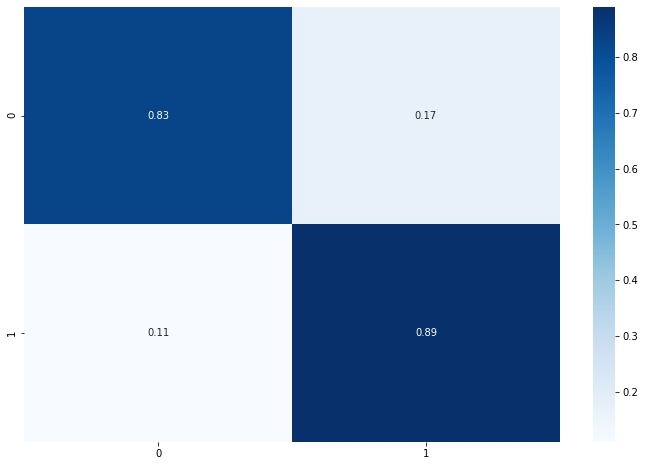



Classification report :

               precision    recall  f1-score   support

           0       0.88      0.83      0.86       100
           1       0.84      0.89      0.86       100

    accuracy                           0.86       200
   macro avg       0.86      0.86      0.86       200
weighted avg       0.86      0.86      0.86       200



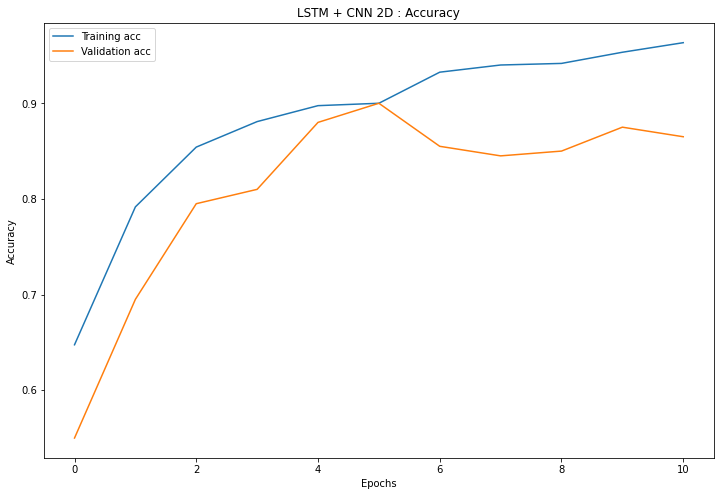

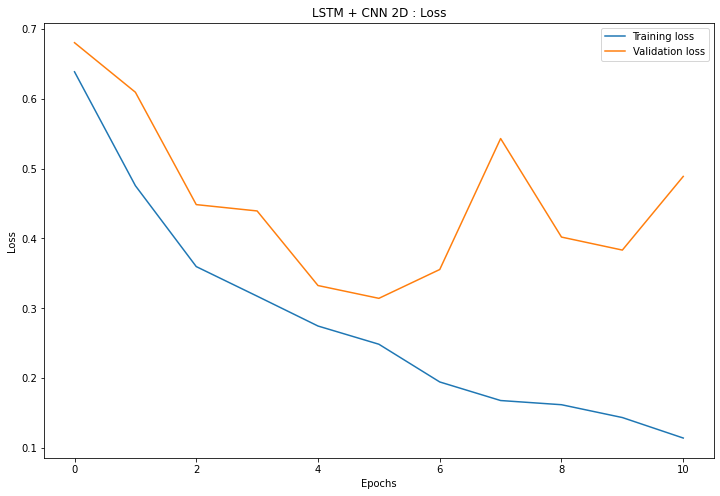

In [ ]:
evaluation('LSTM + CNN 2D', model, patience = 5)

## Notes :

- As we can expect it, results are worse than before (CNN after LSTM but the LSTM output has no spatial meaning)

- Overfitting

## CNN 3D

In [ ]:
model = keras.models.Sequential()

model.add(layers.Masking(mask_value = 0.0, input_shape = (128, 128, None, 1) ))

model.add(layers.Conv3D(filters = 40, kernel_size = (3,3,3), activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(keras.layers.MaxPool3D(pool_size=(2,2,2)))

model.add(layers.Conv3D(filters = 32, kernel_size = (3,3,3), activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(keras.layers.MaxPool3D(pool_size=(2,2,2)))

model.add(layers.GlobalMaxPooling3D())

model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [ ]:
model.compile(optimizer= keras.optimizers.Adam(lr_schedule), loss = 'binary_crossentropy', metrics = 'accuracy')

Epoch 1/50
150/150 [==============================] - 32s 206ms/step - loss: 0.6814 - accuracy: 0.5448 - val_loss: 0.5219 - val_accuracy: 0.7850
Epoch 2/50
150/150 [==============================] - 31s 205ms/step - loss: 0.4957 - accuracy: 0.7682 - val_loss: 0.3605 - val_accuracy: 0.8800
Epoch 3/50
150/150 [==============================] - 31s 204ms/step - loss: 0.3105 - accuracy: 0.8763 - val_loss: 0.2803 - val_accuracy: 0.8850
Epoch 4/50
150/150 [==============================] - 31s 204ms/step - loss: 0.2300 - accuracy: 0.8967 - val_loss: 0.3370 - val_accuracy: 0.9150
Epoch 5/50
150/150 [==============================] - 31s 204ms/step - loss: 0.2656 - accuracy: 0.9073 - val_loss: 0.2034 - val_accuracy: 0.9300
Epoch 6/50
150/150 [==============================] - 31s 204ms/step - loss: 0.1745 - accuracy: 0.9418 - val_loss: 0.2442 - val_accuracy: 0.9400
Epoch 7/50
150/150 [==============================] - 31s 204ms/step - loss: 0.1834 - accuracy: 0.9287 - val_loss: 0.1695 - val_ac

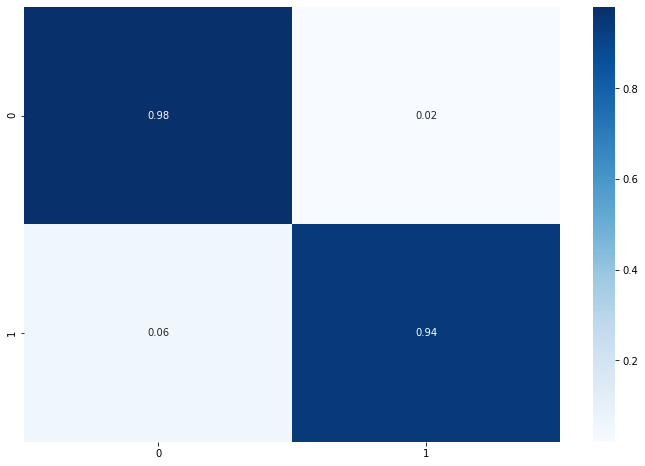



Classification report :

               precision    recall  f1-score   support

           0       0.94      0.98      0.96       100
           1       0.98      0.94      0.96       100

    accuracy                           0.96       200
   macro avg       0.96      0.96      0.96       200
weighted avg       0.96      0.96      0.96       200



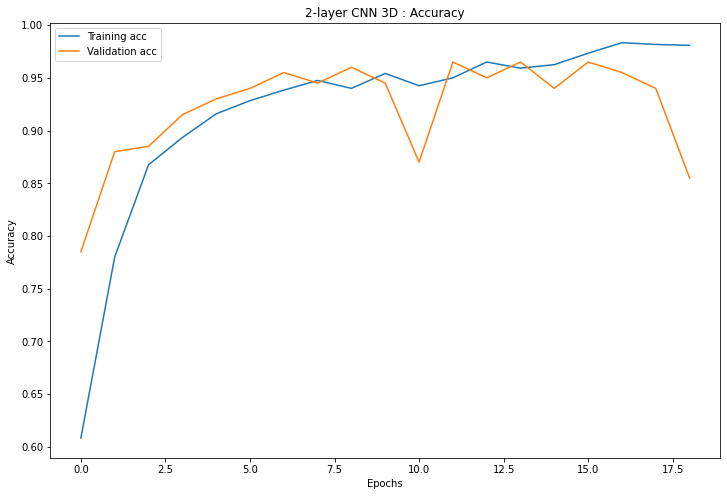

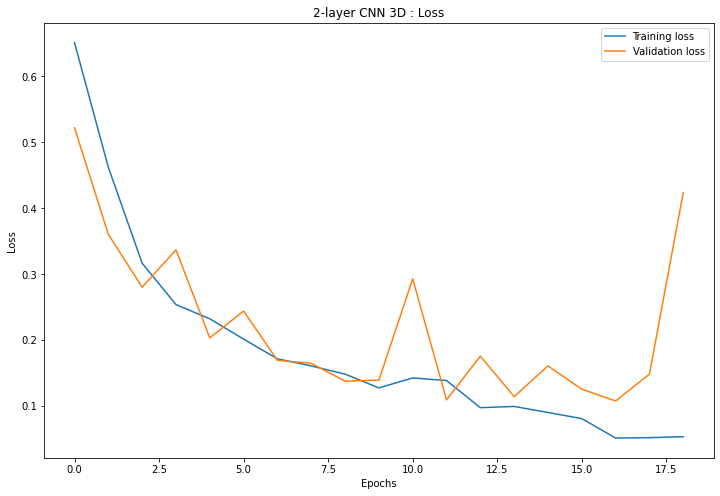

In [ ]:
evaluation('2-layer CNN 3D', model, patience = 7)

In [ ]:
model.save('drive/MyDrive/modeles/2_CNN_3D.h5')

In [ ]:
model = keras.models.Sequential()

model.add(layers.Masking(mask_value = 0.0, input_shape = (128, 128, None, 1) ))
model.add(layers.Conv3D(filters = 42, kernel_size = (3,3,5), activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(keras.layers.MaxPool3D(pool_size=(2,2,2)))
model.add(layers.BatchNormalization())

model.add(layers.Conv3D(filters = 32, kernel_size = (3,3,5), activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(keras.layers.MaxPool3D(pool_size=(2,2,2)))
model.add(layers.BatchNormalization())

model.add(layers.Conv3D(filters = 16, kernel_size = (3,3,5), activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(keras.layers.MaxPool3D(pool_size=(2,2,2)))
model.add(layers.BatchNormalization())

model.add(layers.GlobalMaxPooling3D())

model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [ ]:
model.compile(optimizer= keras.optimizers.Adam(lr_schedule), loss = 'binary_crossentropy', metrics = 'accuracy')

Epoch 1/50
150/150 [==============================] - 73s 471ms/step - loss: 1.0794 - accuracy: 0.5795 - val_loss: 0.8938 - val_accuracy: 0.5000
Epoch 2/50
150/150 [==============================] - 63s 422ms/step - loss: 0.4690 - accuracy: 0.8072 - val_loss: 1.2562 - val_accuracy: 0.5000
Epoch 3/50
150/150 [==============================] - 63s 423ms/step - loss: 0.2795 - accuracy: 0.8714 - val_loss: 1.2712 - val_accuracy: 0.5000
Epoch 4/50
150/150 [==============================] - 63s 422ms/step - loss: 0.2743 - accuracy: 0.8871 - val_loss: 1.0880 - val_accuracy: 0.5350
Epoch 5/50
150/150 [==============================] - 63s 421ms/step - loss: 0.2430 - accuracy: 0.9062 - val_loss: 0.8894 - val_accuracy: 0.5450
Epoch 6/50
150/150 [==============================] - 63s 422ms/step - loss: 0.1887 - accuracy: 0.9334 - val_loss: 0.6827 - val_accuracy: 0.6800
Epoch 7/50
150/150 [==============================] - 63s 421ms/step - loss: 0.1655 - accuracy: 0.9390 - val_loss: 0.2799 - val_ac

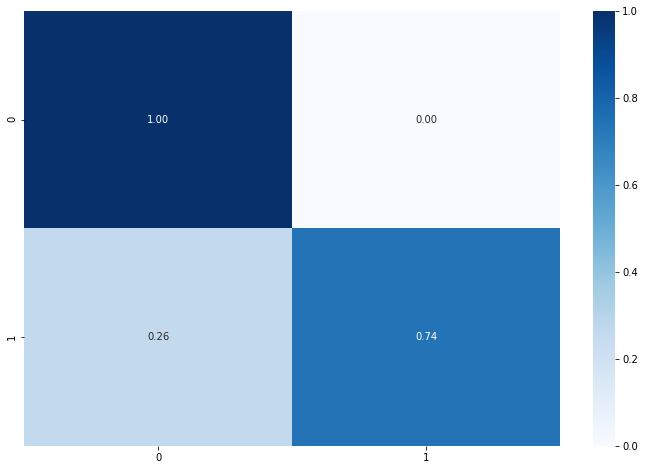



Classification report :

               precision    recall  f1-score   support

           0       0.79      1.00      0.88       100
           1       1.00      0.74      0.85       100

    accuracy                           0.87       200
   macro avg       0.90      0.87      0.87       200
weighted avg       0.90      0.87      0.87       200



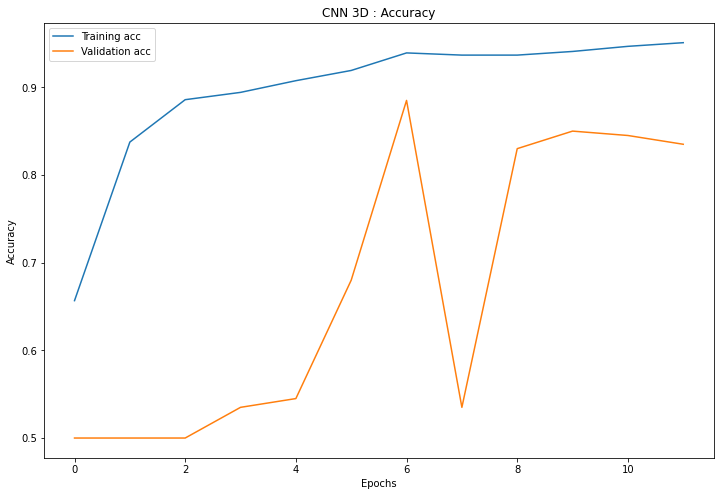

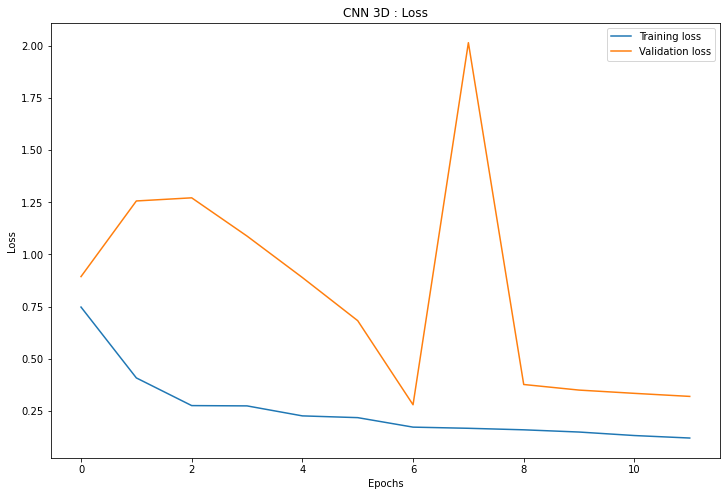

In [ ]:
evaluation('CNN 3D', model, patience = 5)

In [ ]:
model.save('drive/MyDrive/modeles/CNN_3D_perfect_class_0.h5')

## Notes : 

- Very high performance

- No overfitting

- Quite stable through epochs

- Robust to the data (0.965 for val vs 0.960 for test)

## CNN 3D + LSTM

In [ ]:
model = keras.models.Sequential()

model.add(layers.Masking(mask_value = 0.0, input_shape = (128, 128, None, 1) ))

model.add(layers.Conv3D(filters = 32, kernel_size = (3,3,3), activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(keras.layers.MaxPool3D(pool_size=(2,2,2)))

model.add(layers.Conv3D(filters = 32, kernel_size = (3,3,3), activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(keras.layers.MaxPool3D(pool_size=(2,2,2)))

model.add(layers.Reshape((-1, 30*30*32)))

model.add(layers.LSTM(units = 16, 
                      activation ='tanh', 
                      recurrent_activation='sigmoid', 
                      return_sequences=True))

model.add(layers.GlobalMaxPooling1D())

model.add(layers.Dropout(0.2))
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 128, 128, None, 1) 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 126, 126, None, 32 896       
_________________________________________________________________
dropout (Dropout)            (None, 126, 126, None, 32 0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 63, 63, None, 32)  0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 61, 61, None, 32)  27680     
_________________________________________________________________
dropout_1 (Dropout)          (None, 61, 61, None, 32)  0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 30, 30, None, 32)  0

In [ ]:
model.compile(optimizer= keras.optimizers.Adam(lr_schedule), loss = 'binary_crossentropy', metrics = 'accuracy')

Epoch 1/50
150/150 [==============================] - 193s 1s/step - loss: 0.6577 - accuracy: 0.5913 - val_loss: 0.5652 - val_accuracy: 0.6650
Epoch 2/50
150/150 [==============================] - 38s 256ms/step - loss: 0.5019 - accuracy: 0.7482 - val_loss: 0.3186 - val_accuracy: 0.8700
Epoch 3/50
150/150 [==============================] - 38s 256ms/step - loss: 0.3681 - accuracy: 0.8393 - val_loss: 0.3678 - val_accuracy: 0.8550
Epoch 4/50
150/150 [==============================] - 38s 255ms/step - loss: 0.3368 - accuracy: 0.8410 - val_loss: 0.3430 - val_accuracy: 0.8550
Epoch 5/50
150/150 [==============================] - 38s 255ms/step - loss: 0.3267 - accuracy: 0.8545 - val_loss: 0.2830 - val_accuracy: 0.8750
Epoch 6/50
150/150 [==============================] - 38s 255ms/step - loss: 0.2653 - accuracy: 0.8858 - val_loss: 0.2880 - val_accuracy: 0.8650
Epoch 7/50
150/150 [==============================] - 38s 256ms/step - loss: 0.1955 - accuracy: 0.9210 - val_loss: 0.2783 - val_accu

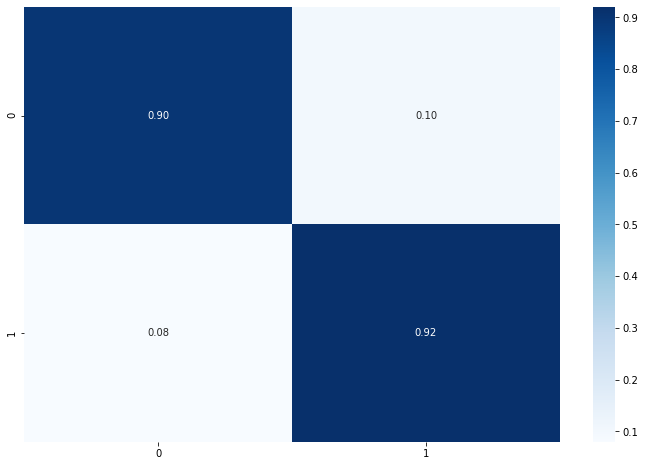



Classification report :

               precision    recall  f1-score   support

           0       0.92      0.90      0.91       100
           1       0.90      0.92      0.91       100

    accuracy                           0.91       200
   macro avg       0.91      0.91      0.91       200
weighted avg       0.91      0.91      0.91       200



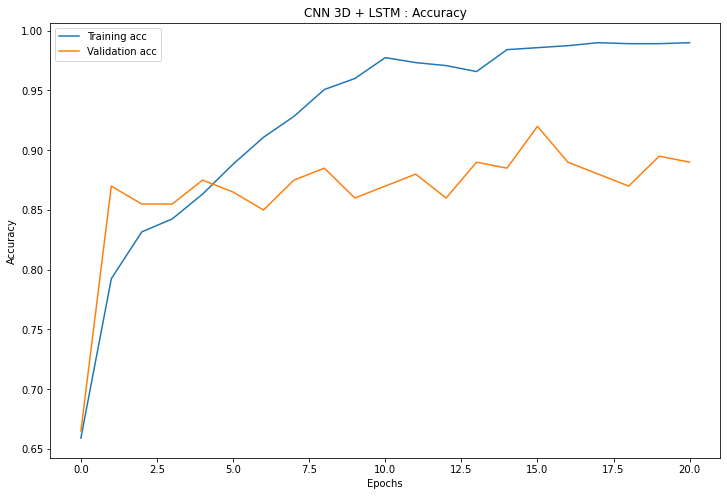

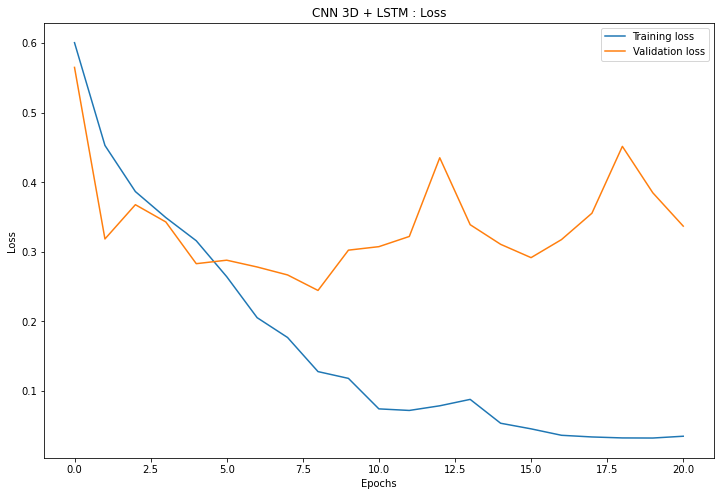

In [ ]:
evaluation('CNN 3D + LSTM', model, patience = 5)

In [ ]:
model = models.Sequential()

model.add(layers.Masking(mask_value = 0.0, input_shape = (128, 128, None, 1) ))

model.add(layers.Conv3D(filters = 32, kernel_size = (3,3,3), activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(keras.layers.MaxPool3D(pool_size=(2,2,2)))

model.add(layers.Conv3D(filters = 32, kernel_size = (3,3,3), activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(keras.layers.MaxPool3D(pool_size=(2,2,2)))

model.add(layers.Reshape((-1, 30, 30, 32)))

model.add(layers.ConvLSTM2D(filters=15, kernel_size=(5, 5), padding="valid", return_sequences=True))
model.add(layers.Dropout(0.4))
model.add(layers.BatchNormalization())
model.add(layers.GlobalMaxPooling3D())


model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_2 (Masking)          (None, 128, 128, None, 1) 0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 126, 126, None, 32 896       
_________________________________________________________________
dropout_9 (Dropout)          (None, 126, 126, None, 32 0         
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 63, 63, None, 32)  0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 61, 61, None, 32)  27680     
_________________________________________________________________
dropout_10 (Dropout)         (None, 61, 61, None, 32)  0         
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 30, 30, None, 32) 

In [ ]:
model.compile(optimizer= keras.optimizers.Adam(lr_schedule), loss = 'binary_crossentropy', metrics = 'accuracy')

Epoch 1/50
150/150 [==============================] - 72s 453ms/step - loss: 0.7366 - accuracy: 0.6555 - val_loss: 0.6104 - val_accuracy: 0.6650
Epoch 2/50
150/150 [==============================] - 54s 361ms/step - loss: 0.2975 - accuracy: 0.8758 - val_loss: 0.5277 - val_accuracy: 0.8250
Epoch 3/50
150/150 [==============================] - 54s 361ms/step - loss: 0.2659 - accuracy: 0.8844 - val_loss: 0.3679 - val_accuracy: 0.9400
Epoch 4/50
150/150 [==============================] - 54s 361ms/step - loss: 0.2053 - accuracy: 0.9183 - val_loss: 0.3406 - val_accuracy: 0.9350
Epoch 5/50
150/150 [==============================] - 54s 361ms/step - loss: 0.2677 - accuracy: 0.8809 - val_loss: 0.2731 - val_accuracy: 0.8900
Epoch 6/50
150/150 [==============================] - 54s 359ms/step - loss: 0.2515 - accuracy: 0.8904 - val_loss: 0.3345 - val_accuracy: 0.8400
Epoch 7/50
150/150 [==============================] - 54s 360ms/step - loss: 0.1350 - accuracy: 0.9501 - val_loss: 0.2653 - val_ac

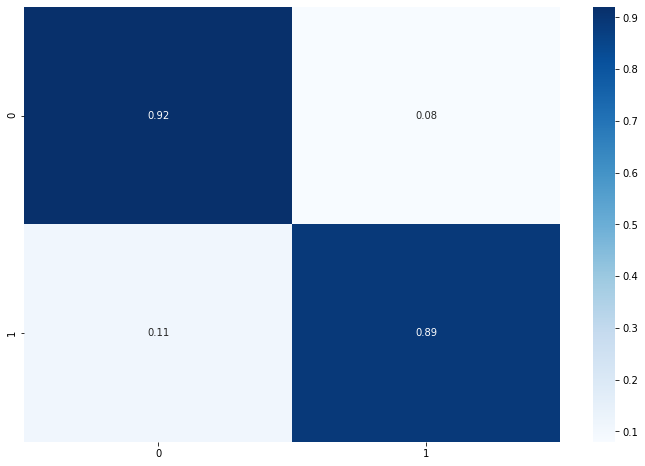



Classification report :

               precision    recall  f1-score   support

           0       0.89      0.92      0.91       100
           1       0.92      0.89      0.90       100

    accuracy                           0.91       200
   macro avg       0.91      0.91      0.90       200
weighted avg       0.91      0.91      0.90       200



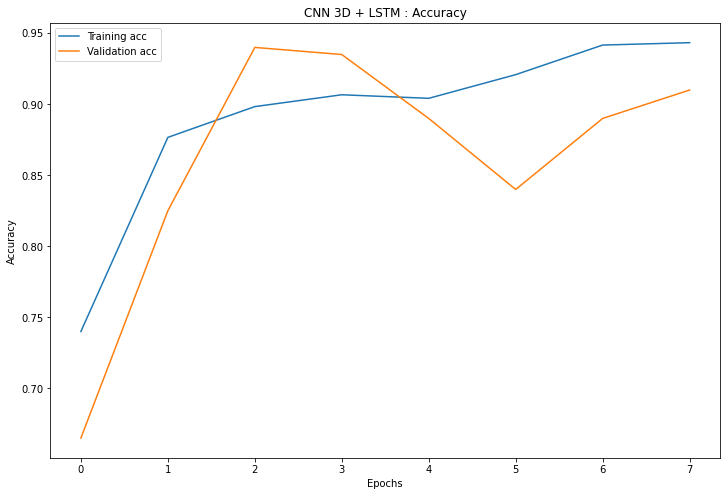

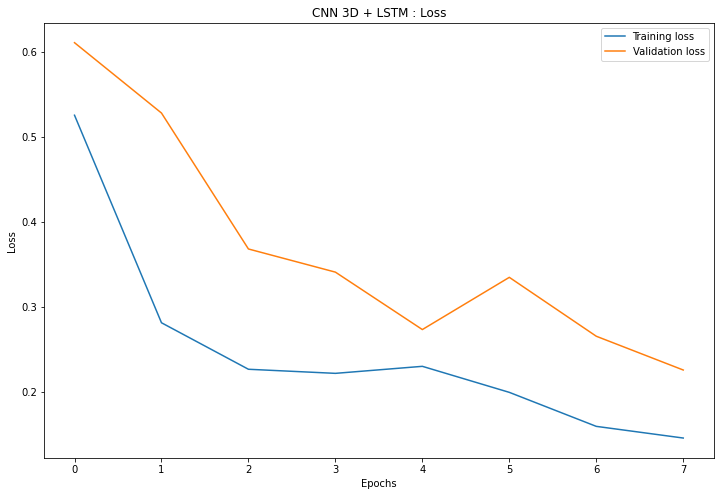

In [ ]:
evaluation('CNN 3D + LSTM', model, patience = 5)

## Notes :

- Worse than 3D CNN alone

- Overfitting

## LSTM + 3D CNN

In [ ]:
model = keras.models.Sequential()

model.add(layers.Masking(mask_value = 0.0, input_shape = (None, 128*128)))

model.add(layers.LSTM(units = 100, 
                      activation ='tanh', 
                      recurrent_activation='sigmoid', 
                      return_sequences=True))

layers.Dropout(0.5)

model.add(layers.Reshape((10, 10, -1, 1)))

model.add(layers.Conv3D(filters = 32, kernel_size = (3,3,3), activation = 'relu', padding = 'same'))
model.add(layers.BatchNormalization())

model.add(layers.Conv3D(filters = 32, kernel_size = (3,3,3), activation = 'relu', padding = 'same'))
model.add(keras.layers.MaxPool3D(pool_size=(2,2,2)))
model.add(layers.BatchNormalization())

model.add(layers.GlobalMaxPooling3D())

model.add(layers.Dense(32, activation = 'relu'))
layers.Dropout(0.3)
model.add(layers.Dense(1, activation = 'sigmoid'))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_2 (Masking)          (None, None, 16384)       0         
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 100)         6594000   
_________________________________________________________________
reshape (Reshape)            (None, 10, 10, None, 1)   0         
_________________________________________________________________
conv3d (Conv3D)              (None, 10, 10, None, 32)  896       
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 10, None, 32)  128       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 10, 10, None, 32)  27680     
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 5, 5, None, 32)   

In [ ]:
model.compile(optimizer= keras.optimizers.Adam(lr_schedule), loss = 'binary_crossentropy', metrics = 'accuracy')

Epoch 1/50
150/150 [==============================] - 46s 267ms/step - loss: 0.8545 - accuracy: 0.5416 - val_loss: 0.7049 - val_accuracy: 0.5450
Epoch 2/50
150/150 [==============================] - 37s 248ms/step - loss: 0.5606 - accuracy: 0.7210 - val_loss: 0.6238 - val_accuracy: 0.6100
Epoch 3/50
150/150 [==============================] - 37s 247ms/step - loss: 0.3641 - accuracy: 0.8556 - val_loss: 0.6015 - val_accuracy: 0.6750
Epoch 4/50
150/150 [==============================] - 37s 247ms/step - loss: 0.2820 - accuracy: 0.9025 - val_loss: 0.4482 - val_accuracy: 0.8300
Epoch 5/50
150/150 [==============================] - 37s 247ms/step - loss: 0.2659 - accuracy: 0.9031 - val_loss: 0.5269 - val_accuracy: 0.7800
Epoch 6/50
150/150 [==============================] - 37s 246ms/step - loss: 0.2784 - accuracy: 0.8732 - val_loss: 0.5318 - val_accuracy: 0.7950
Epoch 7/50
150/150 [==============================] - 37s 246ms/step - loss: 0.2475 - accuracy: 0.9040 - val_loss: 0.3919 - val_ac

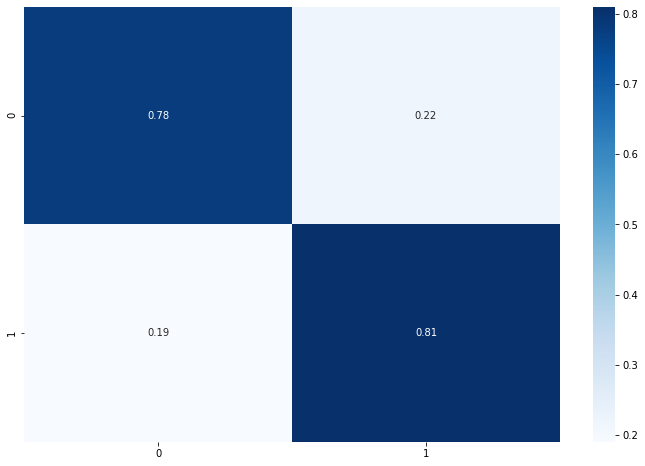



Classification report :

               precision    recall  f1-score   support

           0       0.80      0.78      0.79       100
           1       0.79      0.81      0.80       100

    accuracy                           0.80       200
   macro avg       0.80      0.80      0.79       200
weighted avg       0.80      0.80      0.79       200



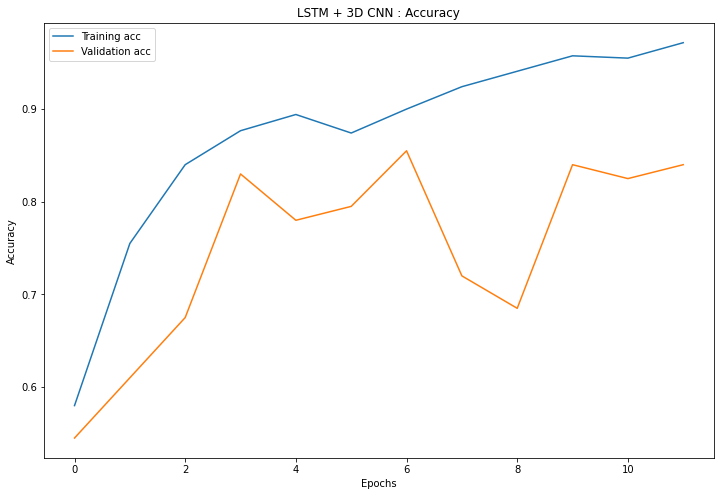

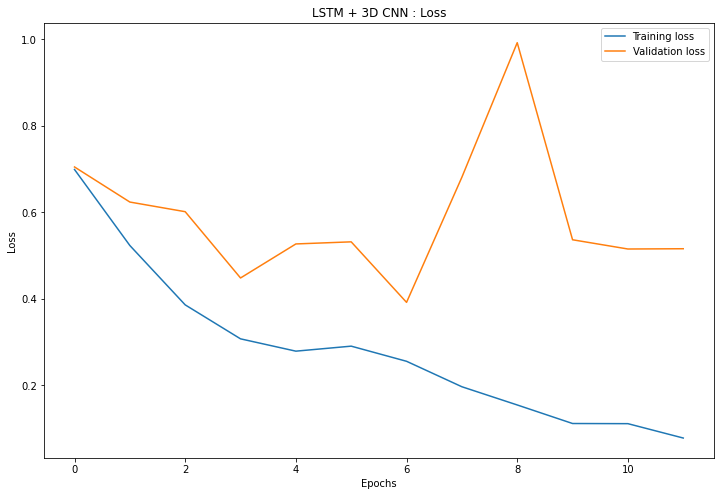

In [ ]:
evaluation('LSTM + 3D CNN', model, patience = 5)

## Notes : 

- Bad performance (as we can expect)

- Overfitting

## VGG16 + LSTM

In [ ]:
base_model = keras.applications.VGG16(weights = 'imagenet',
                                         input_shape = (64, 64, 3),
                                         include_top = False)

We fine-tune only the Conv block 5 (and the fully connected)

In [ ]:
base_model.trainable = True

set_trainable = False
for layer in base_model.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
model = models.Sequential()

# This Conv enables us to get 3 channels (required for VGG16)
model.add(layers.TimeDistributed(layers.Conv2D(filters = 3, kernel_size = (1, 1), padding = 'same')))
model.add(layers.TimeDistributed(layers.MaxPooling2D((2,2))))
model.add(layers.TimeDistributed(base_model))
model.add(layers.TimeDistributed(layers.Flatten()))

model.add(layers.LSTM(units = 32, 
                      activation ='tanh', 
                      recurrent_activation='sigmoid', 
                      return_sequences=True))

model.add(layers.LSTM(units = 32, 
                      activation ='tanh', 
                      recurrent_activation='sigmoid', 
                      return_sequences=True))

model.add(layers.GlobalMaxPooling1D())

model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [14]:
initial_learning_rate = 1e-4
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

In [ ]:
model.compile(optimizer= keras.optimizers.Adam(lr_schedule), loss = 'binary_crossentropy', metrics = 'accuracy')

Epoch 1/50
150/150 [==============================] - 49s 294ms/step - loss: 0.6608 - accuracy: 0.6390 - val_loss: 0.5700 - val_accuracy: 0.7900
Epoch 2/50
150/150 [==============================] - 43s 286ms/step - loss: 0.5782 - accuracy: 0.7384 - val_loss: 0.4782 - val_accuracy: 0.8050
Epoch 3/50
150/150 [==============================] - 43s 286ms/step - loss: 0.4747 - accuracy: 0.7975 - val_loss: 0.3893 - val_accuracy: 0.8450
Epoch 4/50
150/150 [==============================] - 43s 286ms/step - loss: 0.4010 - accuracy: 0.8304 - val_loss: 0.3185 - val_accuracy: 0.8550
Epoch 5/50
150/150 [==============================] - 43s 286ms/step - loss: 0.3181 - accuracy: 0.8763 - val_loss: 0.2664 - val_accuracy: 0.9050
Epoch 6/50
150/150 [==============================] - 43s 286ms/step - loss: 0.2681 - accuracy: 0.8988 - val_loss: 0.2458 - val_accuracy: 0.9000
Epoch 7/50
150/150 [==============================] - 43s 286ms/step - loss: 0.2499 - accuracy: 0.9022 - val_loss: 0.2140 - val_ac

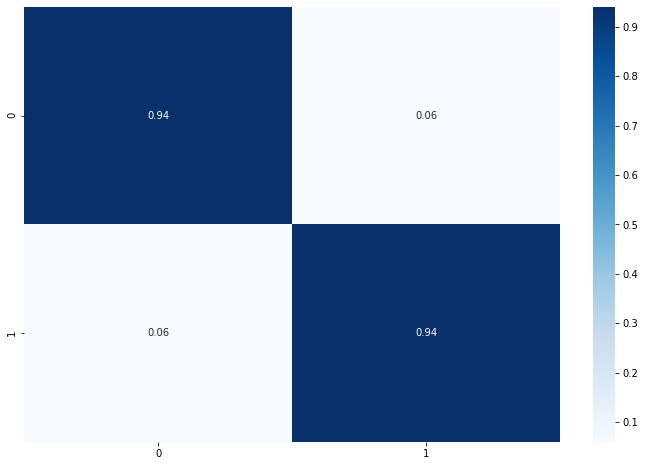



Classification report :

               precision    recall  f1-score   support

           0       0.94      0.94      0.94       100
           1       0.94      0.94      0.94       100

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.94       200
weighted avg       0.94      0.94      0.94       200



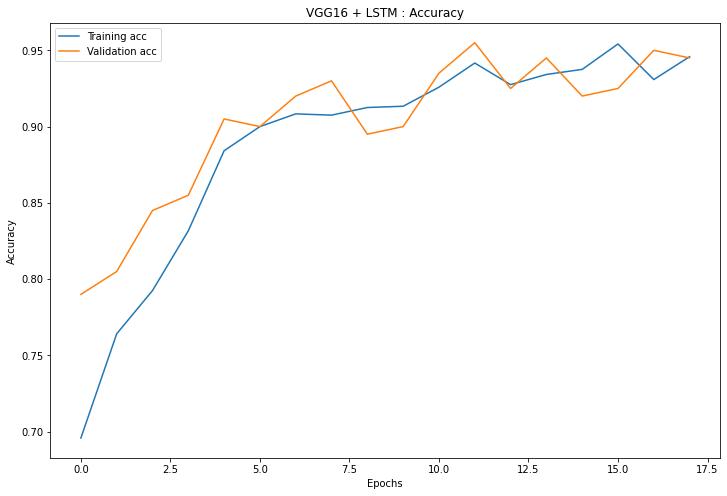

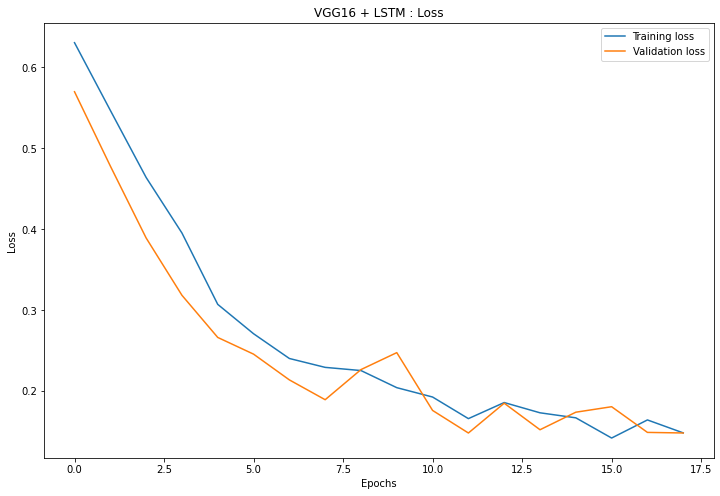

In [ ]:
evaluation('VGG16 + LSTM', model, patience = 6)

In [ ]:
model.save('drive/MyDrive/modeles/VGG16_LSTM.h5')

## Notes : 

- Performance similar to CNN 2D + LSTM 

- So Transfer Learning isn't really useful here

- This NN is more stable through epochs though

## Influence of "*temporality*"

### LSTM vs no LSTM (Naive MLP)

In [ ]:
model = models.Sequential()

model.add(layers.Masking(mask_value = 0.0, input_shape = (None, 128*128)))

model.add(layers.LSTM(units = 32, 
                      activation ='tanh', 
                      recurrent_activation='sigmoid', 
                      return_sequences=False))

model.add(layers.Dropout(0.4))

model.add(layers.Dense(16, activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [ ]:
model.compile(optimizer= 'Adam', loss = 'binary_crossentropy', metrics = 'accuracy')

In [ ]:
lstm_history =  model.fit(train_gen,
                         steps_per_epoch=None,
                         epochs=30,
                         validation_data=val_gen,
                         validation_steps=None)

Epoch 1/30
150/150 [==============================] - 42s 249ms/step - loss: 0.6965 - accuracy: 0.5454 - val_loss: 0.6192 - val_accuracy: 0.7000
Epoch 2/30
150/150 [==============================] - 36s 239ms/step - loss: 0.5954 - accuracy: 0.7087 - val_loss: 0.5873 - val_accuracy: 0.7000
Epoch 3/30
150/150 [==============================] - 36s 238ms/step - loss: 0.5884 - accuracy: 0.7007 - val_loss: 0.5049 - val_accuracy: 0.7750
Epoch 4/30
150/150 [==============================] - 36s 239ms/step - loss: 0.5134 - accuracy: 0.7660 - val_loss: 0.5473 - val_accuracy: 0.7100
Epoch 5/30
150/150 [==============================] - 36s 239ms/step - loss: 0.4780 - accuracy: 0.7587 - val_loss: 0.4396 - val_accuracy: 0.8100
Epoch 6/30
150/150 [==============================] - 36s 238ms/step - loss: 0.4439 - accuracy: 0.8029 - val_loss: 0.4327 - val_accuracy: 0.8250
Epoch 7/30
150/150 [==============================] - 36s 239ms/step - loss: 0.3271 - accuracy: 0.8711 - val_loss: 0.4496 - val_ac

In [ ]:
''' Modify the shape of data : instead of considering sequence of images, we decorrelate the frames so that each frame represents a sample (with the right label).

    Ex : a normal sample with a time step of 90 leads to 90 normal samples, each sample being a single image.

'''

class DataGeneratorNaive(keras.utils.Sequence):

  def __init__(self, path, is_img = False):
          self.path = path
          self.is_img = is_img

  def __len__(self):
      return len(os.listdir(self.path))

  def __getitem__(self, idx):
    input = open(os.path.join(self.path, f'batch{idx}.pickle'), 'rb')
    X_seq, y_seq = pickle.load(input)
    input.close()
    len = y_seq.shape[0]
    time_step = X_seq.shape[1]
    X = X_seq.reshape((X_seq.shape[0]*X_seq.shape[1], 128*128*1))
    y = np.zeros((X.shape[0], 1))
    for i in range(len):
      y[i*time_step:(i+1)*time_step] = y_seq[i]
    if self.is_img:
      X = X.reshape((X.shape[0], 128, 128, 1))
    return X, y

In [ ]:
naive_train_gen = DataGeneratorNaive('drive/MyDrive/train', is_img = False)
naive_val_gen = DataGeneratorNaive('drive/MyDrive/val', is_img = False)
naive_test_gen = DataGeneratorNaive('drive/MyDrive/test', is_img = False)

In [ ]:
# Naive MLP

model = models.Sequential()

model.add(layers.Masking(mask_value = 0.0, input_shape = (None, 128*128)))

model.add(layers.Dense(32, activation = 'tanh'))

model.add(layers.Dropout(0.4))

model.add(layers.Dense(16, activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [ ]:
model.compile(optimizer= 'Adam', loss = 'binary_crossentropy', metrics = 'accuracy')

In [ ]:
naive_history =  model.fit(naive_train_gen,
                         steps_per_epoch=None,
                         epochs=30,
                         validation_data=naive_val_gen,
                         validation_steps=None)

Epoch 1/30
150/150 [==============================] - 15s 99ms/step - loss: 0.3120 - accuracy: 0.6000 - val_loss: 0.2397 - val_accuracy: 0.7426
Epoch 2/30
150/150 [==============================] - 14s 96ms/step - loss: 0.2665 - accuracy: 0.7051 - val_loss: 0.2133 - val_accuracy: 0.7784
Epoch 3/30
150/150 [==============================] - 15s 97ms/step - loss: 0.2464 - accuracy: 0.7516 - val_loss: 0.2134 - val_accuracy: 0.7909
Epoch 4/30
150/150 [==============================] - 14s 95ms/step - loss: 0.2455 - accuracy: 0.7479 - val_loss: 0.2095 - val_accuracy: 0.7749
Epoch 5/30
150/150 [==============================] - 14s 96ms/step - loss: 0.2202 - accuracy: 0.7813 - val_loss: 0.1975 - val_accuracy: 0.8078
Epoch 6/30
150/150 [==============================] - 15s 97ms/step - loss: 0.2180 - accuracy: 0.7886 - val_loss: 0.1919 - val_accuracy: 0.8165
Epoch 7/30
150/150 [==============================] - 14s 96ms/step - loss: 0.2160 - accuracy: 0.7866 - val_loss: 0.1888 - val_accuracy:

In [ ]:
model.evaluate(naive_test_gen)

25/25 [==============================] - 20s 848ms/step - loss: 0.2121 - accuracy: 0.8097


[0.21212302148342133, 0.8097211718559265]

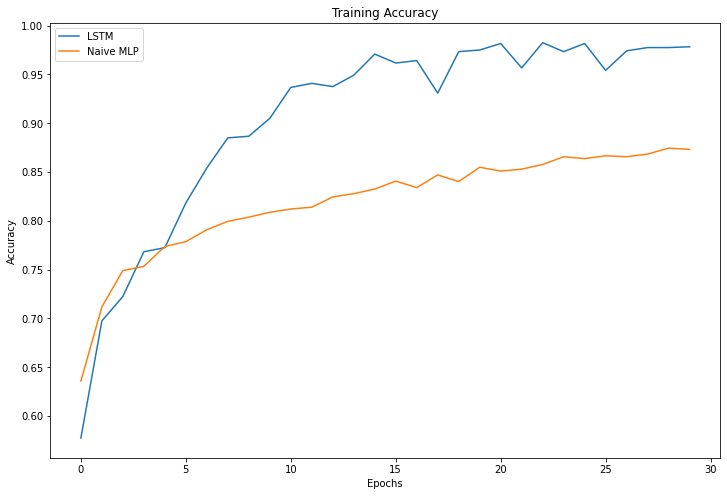

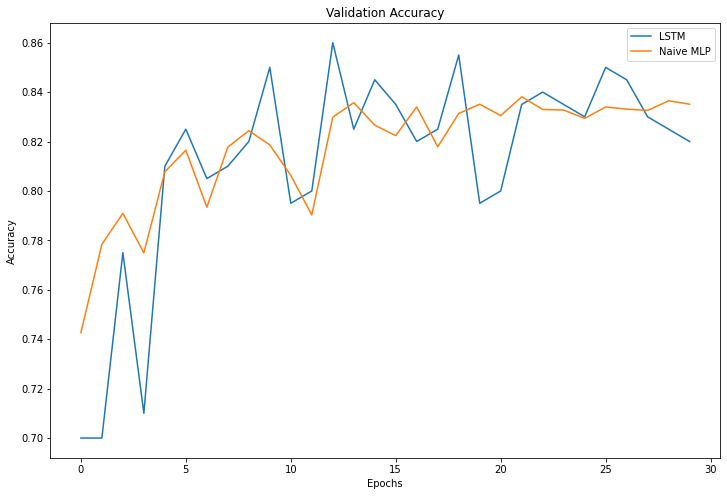

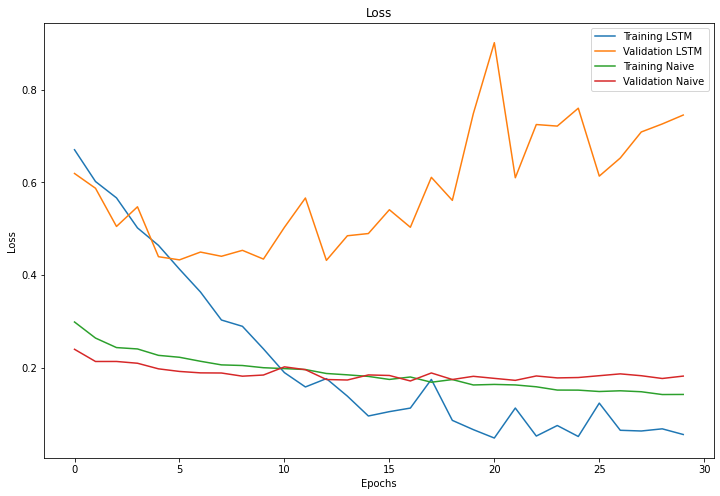

In [ ]:
acc = lstm_history.history['accuracy']
val_acc = lstm_history.history['val_accuracy']
loss = lstm_history.history['loss']
val_loss = lstm_history.history['val_loss']

naive_acc = naive_history.history['accuracy']
naive_val_acc = naive_history.history['val_accuracy']
naive_loss = naive_history.history['loss']
naive_val_loss = naive_history.history['val_loss']

plt.figure(figsize=(12,8))
plt.plot(acc, label='LSTM')
plt.plot(naive_acc, label = 'Naive MLP')
plt.title('Training Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.figure(figsize=(12,8))
plt.plot(val_acc, label='LSTM')
plt.plot(naive_val_acc, label = 'Naive MLP')
plt.title('Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


plt.figure(figsize=(12,8))
plt.plot(loss, label='Training LSTM')
plt.plot(val_loss, label='Validation LSTM')
plt.plot(naive_loss, label = 'Training Naive')
plt.plot(naive_val_loss, label = 'Validation Naive')
plt.title('Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

### CNN 2D + LSTM vs naive CNN 2D

In [ ]:
model = models.Sequential()

model.add(layers.TimeDistributed(layers.Conv2D(32, (3,3), activation = 'relu'), input_shape = (None, 128, 128, 1)))
model.add(layers.TimeDistributed(layers.MaxPool2D(pool_size = (2,2))))
model.add(layers.TimeDistributed(layers.BatchNormalization()))

model.add(layers.TimeDistributed(layers.Conv2D(32, (3,3), activation = 'relu')))
model.add(layers.TimeDistributed(layers.MaxPool2D(pool_size = (2,2))))
model.add(layers.TimeDistributed(layers.BatchNormalization()))
model.add(layers.TimeDistributed(layers.Flatten()))

model.add(layers.LSTM(units = 32, 
                      activation ='tanh', 
                      recurrent_activation='sigmoid', 
                      return_sequences=False))

model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [ ]:
model.compile(optimizer= 'Adam', loss = 'binary_crossentropy', metrics = 'accuracy')

In [ ]:
cnn_lstm_history =  model.fit(train_gen,
                              steps_per_epoch=None,
                              epochs=30,
                              validation_data=val_gen,
                              validation_steps=None)

Epoch 1/30
150/150 [==============================] - 42s 259ms/step - loss: 0.6661 - accuracy: 0.6119 - val_loss: 0.7661 - val_accuracy: 0.5000
Epoch 2/30
150/150 [==============================] - 22s 148ms/step - loss: 0.6050 - accuracy: 0.7192 - val_loss: 0.6755 - val_accuracy: 0.5000
Epoch 3/30
150/150 [==============================] - 22s 148ms/step - loss: 0.5747 - accuracy: 0.7401 - val_loss: 0.9588 - val_accuracy: 0.5000
Epoch 4/30
150/150 [==============================] - 22s 148ms/step - loss: 0.5520 - accuracy: 0.7243 - val_loss: 0.6473 - val_accuracy: 0.6350
Epoch 5/30
150/150 [==============================] - 22s 148ms/step - loss: 0.4814 - accuracy: 0.7747 - val_loss: 0.7097 - val_accuracy: 0.6150
Epoch 6/30
150/150 [==============================] - 22s 149ms/step - loss: 0.4713 - accuracy: 0.7629 - val_loss: 0.5627 - val_accuracy: 0.6850
Epoch 7/30
150/150 [==============================] - 22s 148ms/step - loss: 0.4203 - accuracy: 0.8093 - val_loss: 0.5310 - val_ac

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (128, 128, 1)))
model.add(layers.MaxPool2D(pool_size = (2,2)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(32, (3,3), activation = 'relu'))
model.add(layers.MaxPool2D(pool_size = (2,2)))
model.add(layers.BatchNormalization())
model.add(layers.Flatten())

model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [ ]:
model.compile(optimizer= 'Adam', loss = 'binary_crossentropy', metrics = 'accuracy')

In [ ]:
naive_train_gen = DataGeneratorNaive('drive/MyDrive/train', is_img = True)
naive_val_gen = DataGeneratorNaive('drive/MyDrive/val', is_img = True)
naive_test_gen = DataGeneratorNaive('drive/MyDrive/test', is_img = True)

In [ ]:
naive_cnn_history =  model.fit(naive_train_gen,
                               steps_per_epoch=None,
                               epochs=30,
                               validation_data=naive_val_gen,
                               validation_steps=None)

Epoch 1/30
150/150 [==============================] - 20s 126ms/step - loss: 0.7192 - accuracy: 0.6038 - val_loss: 0.7436 - val_accuracy: 0.5000
Epoch 2/30
150/150 [==============================] - 19s 125ms/step - loss: 0.5235 - accuracy: 0.6942 - val_loss: 1.2145 - val_accuracy: 0.5000
Epoch 3/30
150/150 [==============================] - 19s 125ms/step - loss: 0.4927 - accuracy: 0.7160 - val_loss: 1.6175 - val_accuracy: 0.5000
Epoch 4/30
150/150 [==============================] - 19s 125ms/step - loss: 0.4714 - accuracy: 0.7308 - val_loss: 1.7157 - val_accuracy: 0.5065
Epoch 5/30
150/150 [==============================] - 19s 125ms/step - loss: 0.4594 - accuracy: 0.7284 - val_loss: 1.4104 - val_accuracy: 0.5822
Epoch 6/30
150/150 [==============================] - 19s 125ms/step - loss: 0.4439 - accuracy: 0.7392 - val_loss: 1.0556 - val_accuracy: 0.5558
Epoch 7/30
150/150 [==============================] - 19s 125ms/step - loss: 0.4422 - accuracy: 0.7419 - val_loss: 0.5567 - val_ac

In [ ]:
model.evaluate(naive_test_gen)

25/25 [==============================] - 2s 93ms/step - loss: 0.5909 - accuracy: 0.7247


[0.5909327268600464, 0.7246865034103394]

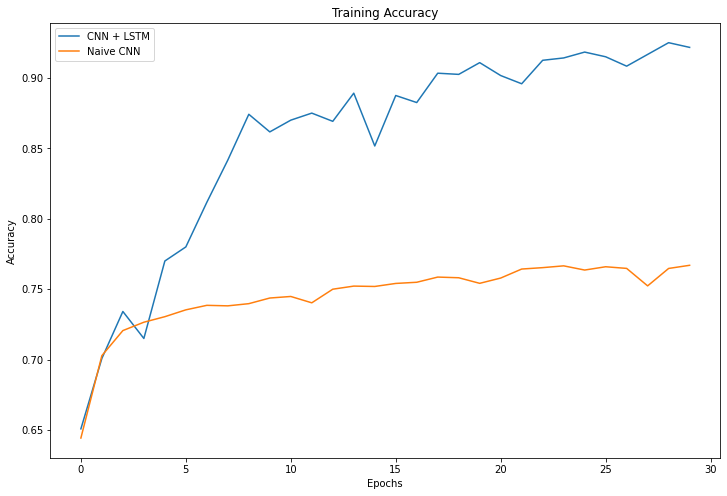

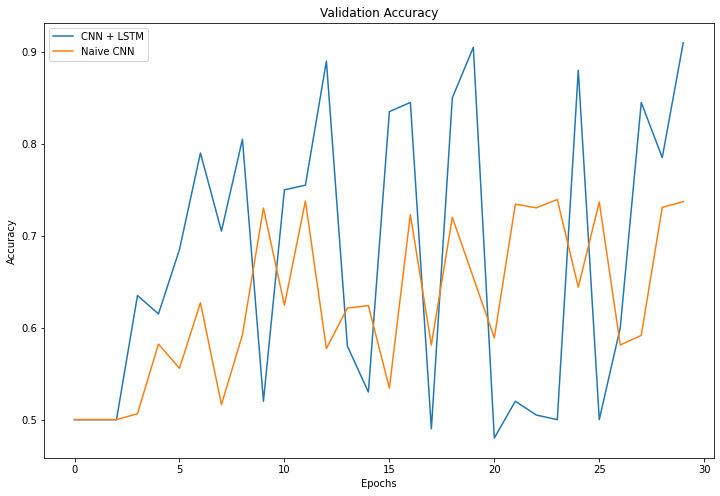

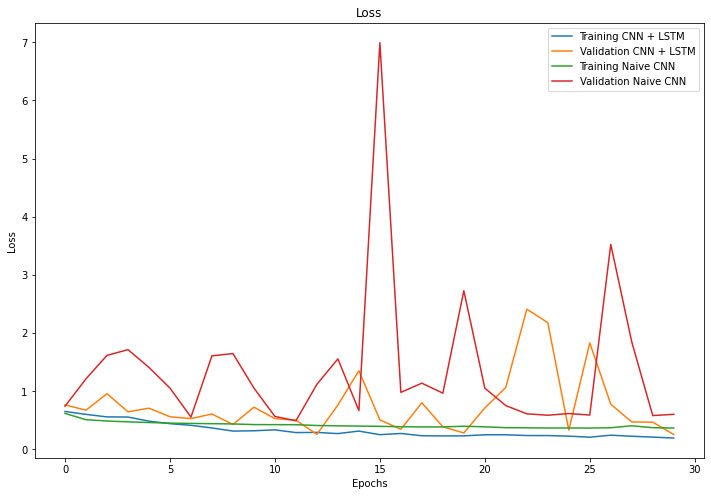

In [ ]:
acc = cnn_lstm_history.history['accuracy']
val_acc = cnn_lstm_history.history['val_accuracy']
loss = cnn_lstm_history.history['loss']
val_loss = cnn_lstm_history.history['val_loss']

naive_acc = naive_cnn_history.history['accuracy']
naive_val_acc = naive_cnn_history.history['val_accuracy']
naive_loss = naive_cnn_history.history['loss']
naive_val_loss = naive_cnn_history.history['val_loss']

plt.figure(figsize=(12,8))
plt.plot(acc,label='CNN + LSTM')
plt.plot(naive_acc, label = 'Naive CNN')
plt.title('Training Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.figure(figsize=(12,8))
plt.plot(val_acc, label='CNN + LSTM')
plt.plot(naive_val_acc, label = 'Naive CNN')
plt.title('Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


plt.figure(figsize=(12,8))
plt.plot(loss, label='Training CNN + LSTM')
plt.plot(val_loss, label='Validation CNN + LSTM')
plt.plot(naive_loss, label = 'Training Naive CNN')
plt.plot(naive_val_loss, label = 'Validation Naive CNN')
plt.title('Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

## Notes :

- Logically, we can observe that models perform much better (on both train and val sets) by keeping the "*temporality*" information than by decorrelating images of sequences

## Influence of convolution

In [ ]:
model = models.Sequential()

model.add(layers.LSTM(units=15, return_sequences=False, input_shape = (None, 128*128)))

model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer= 'Adam', loss = 'binary_crossentropy', metrics = 'accuracy')

In [ ]:
lstm2_history =  model.fit(train_gen,
                         steps_per_epoch=None,
                         epochs=30,
                         validation_data=val_gen,
                         validation_steps=None)

Epoch 1/30
150/150 [==============================] - 18s 106ms/step - loss: 0.5763 - accuracy: 0.7070 - val_loss: 0.4634 - val_accuracy: 0.7950
Epoch 2/30
150/150 [==============================] - 16s 103ms/step - loss: 0.4847 - accuracy: 0.7749 - val_loss: 0.4115 - val_accuracy: 0.8150
Epoch 3/30
150/150 [==============================] - 15s 103ms/step - loss: 0.4496 - accuracy: 0.7982 - val_loss: 0.3949 - val_accuracy: 0.8600
Epoch 4/30
150/150 [==============================] - 16s 104ms/step - loss: 0.4133 - accuracy: 0.8180 - val_loss: 0.3699 - val_accuracy: 0.8150
Epoch 5/30
150/150 [==============================] - 16s 104ms/step - loss: 0.3812 - accuracy: 0.8195 - val_loss: 0.4370 - val_accuracy: 0.7700
Epoch 6/30
150/150 [==============================] - 16s 104ms/step - loss: 0.4108 - accuracy: 0.8046 - val_loss: 0.3353 - val_accuracy: 0.8350
Epoch 7/30
150/150 [==============================] - 16s 104ms/step - loss: 0.3554 - accuracy: 0.8358 - val_loss: 0.3173 - val_ac

In [ ]:
model = models.Sequential()

model.add(layers.ConvLSTM2D(filters=15, kernel_size=(3, 3), return_sequences=False, input_shape = (None, 128, 128, 1)))
model.add(layers.GlobalMaxPooling2D())

model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer= 'Adam', loss = 'binary_crossentropy', metrics = 'accuracy')

In [ ]:
conv_lstm_history =  model.fit(train_gen,
                         steps_per_epoch=None,
                         epochs=30,
                         validation_data=val_gen,
                         validation_steps=None)

Epoch 1/30
150/150 [==============================] - 128s 836ms/step - loss: 0.6813 - accuracy: 0.5487 - val_loss: 0.6490 - val_accuracy: 0.6550
Epoch 2/30
150/150 [==============================] - 125s 832ms/step - loss: 0.6171 - accuracy: 0.6752 - val_loss: 0.6163 - val_accuracy: 0.7250
Epoch 3/30
150/150 [==============================] - 125s 832ms/step - loss: 0.5906 - accuracy: 0.7293 - val_loss: 0.5885 - val_accuracy: 0.7150
Epoch 4/30
150/150 [==============================] - 125s 832ms/step - loss: 0.5429 - accuracy: 0.7315 - val_loss: 0.4659 - val_accuracy: 0.8000
Epoch 5/30
150/150 [==============================] - 125s 832ms/step - loss: 0.4631 - accuracy: 0.7872 - val_loss: 0.5101 - val_accuracy: 0.7450
Epoch 6/30
150/150 [==============================] - 125s 832ms/step - loss: 0.4546 - accuracy: 0.7950 - val_loss: 0.4402 - val_accuracy: 0.7950
Epoch 7/30
150/150 [==============================] - 125s 832ms/step - loss: 0.4036 - accuracy: 0.8135 - val_loss: 0.4301 -

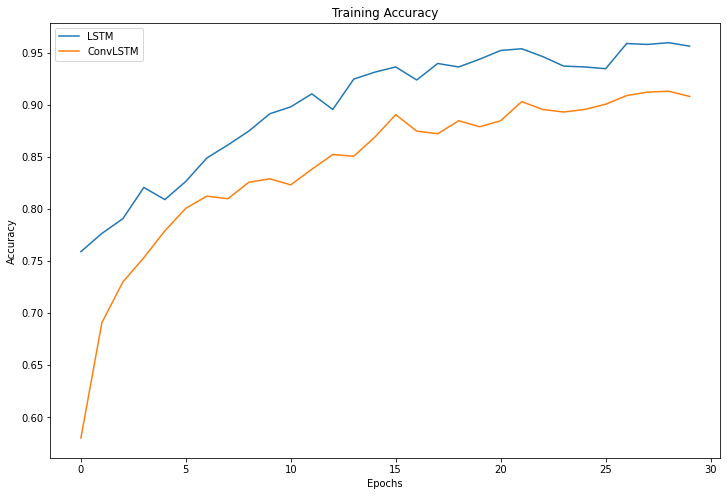

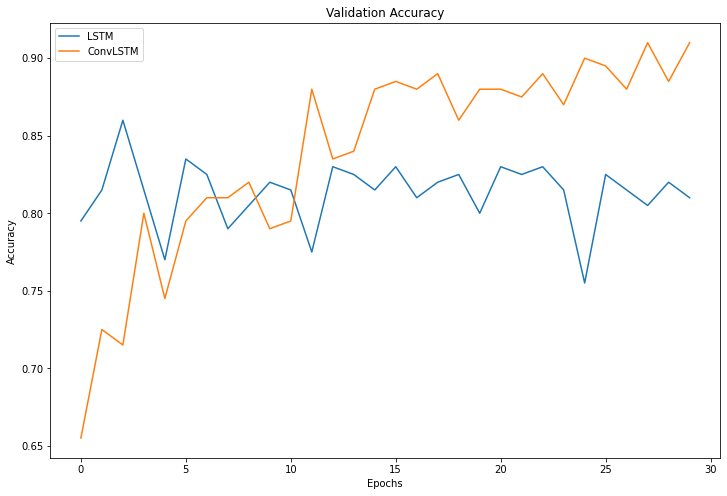

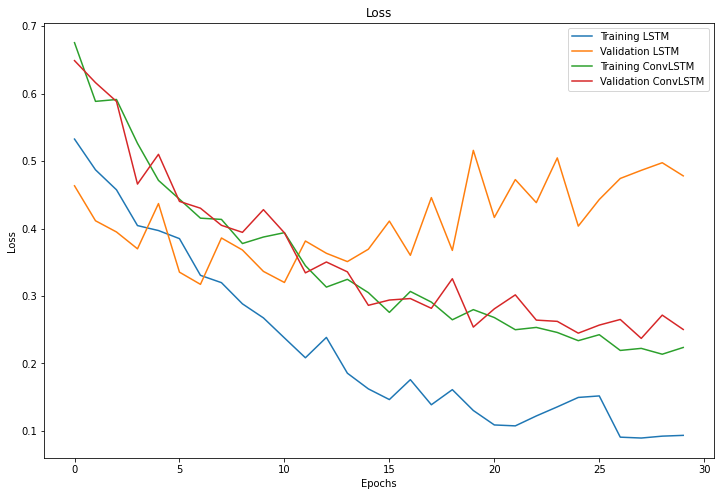

In [ ]:
acc = lstm2_history.history['accuracy']
val_acc = lstm2_history.history['val_accuracy']
loss = lstm2_history.history['loss']
val_loss = lstm2_history.history['val_loss']

conv_acc = conv_lstm_history.history['accuracy']
conv_val_acc = conv_lstm_history.history['val_accuracy']
conv_loss = conv_lstm_history.history['loss']
conv_val_loss = conv_lstm_history.history['val_loss']

plt.figure(figsize=(12,8))
plt.plot(acc,label='LSTM')
plt.plot(conv_acc, label = 'ConvLSTM')
plt.title('Training Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.figure(figsize=(12,8))
plt.plot(val_acc, label='LSTM')
plt.plot(conv_val_acc, label = 'ConvLSTM')
plt.title('Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


plt.figure(figsize=(12,8))
plt.plot(loss, label='Training LSTM')
plt.plot(val_loss, label='Validation LSTM')
plt.plot(conv_loss, label = 'Training ConvLSTM')
plt.plot(conv_val_loss, label = 'Validation ConvLSTM')
plt.title('Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

## Notes :

- Conv LSTM doesn't overfit at all : same performances on both train and val sets (while LSTM overfits a lot)

- So it generalizes better : 90% accuracy for ConvLSTM vs only 83% for LSTM

- The convolutions enable to extract spatial features which are more "general" than pixels (pixels are more dataset sensitive)

## Spatio-temporal vs spatial + temporal (CNN 3D vs CNN 2D + LSTM)

In [ ]:
model = keras.models.Sequential()

model.add(layers.Masking(mask_value = 0.0, input_shape = (128, 128, None, 1) ))

model.add(layers.Conv3D(filters = 32, kernel_size = (3,3,3), activation = 'relu'))
model.add(keras.layers.MaxPool3D(pool_size=(2,2,2)))
model.add(layers.BatchNormalization())

model.add(layers.Conv3D(filters = 32, kernel_size = (3,3,3), activation = 'relu'))
model.add(keras.layers.MaxPool3D(pool_size=(2,2,2)))
model.add(layers.BatchNormalization())

model.add(layers.GlobalMaxPooling3D())

model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [ ]:
model.compile(optimizer= 'Adam', loss = 'binary_crossentropy', metrics = 'accuracy')

In [ ]:
cnn_three_history =  model.fit(train_gen,
                               steps_per_epoch=None,
                               epochs=30,
                               validation_data=val_gen,
                               validation_steps=None)

Epoch 1/30
150/150 [==============================] - 49s 312ms/step - loss: 0.8105 - accuracy: 0.6828 - val_loss: 0.6908 - val_accuracy: 0.5350
Epoch 2/30
150/150 [==============================] - 33s 222ms/step - loss: 0.3024 - accuracy: 0.8943 - val_loss: 0.6547 - val_accuracy: 0.5600
Epoch 3/30
150/150 [==============================] - 33s 222ms/step - loss: 0.2190 - accuracy: 0.9081 - val_loss: 0.3969 - val_accuracy: 0.8950
Epoch 4/30
150/150 [==============================] - 33s 222ms/step - loss: 0.1443 - accuracy: 0.9483 - val_loss: 0.5757 - val_accuracy: 0.7000
Epoch 5/30
150/150 [==============================] - 33s 222ms/step - loss: 0.0969 - accuracy: 0.9642 - val_loss: 0.4511 - val_accuracy: 0.8100
Epoch 6/30
150/150 [==============================] - 33s 222ms/step - loss: 0.0657 - accuracy: 0.9746 - val_loss: 0.2501 - val_accuracy: 0.9250
Epoch 7/30
150/150 [==============================] - 33s 223ms/step - loss: 0.0452 - accuracy: 0.9888 - val_loss: 0.4198 - val_ac

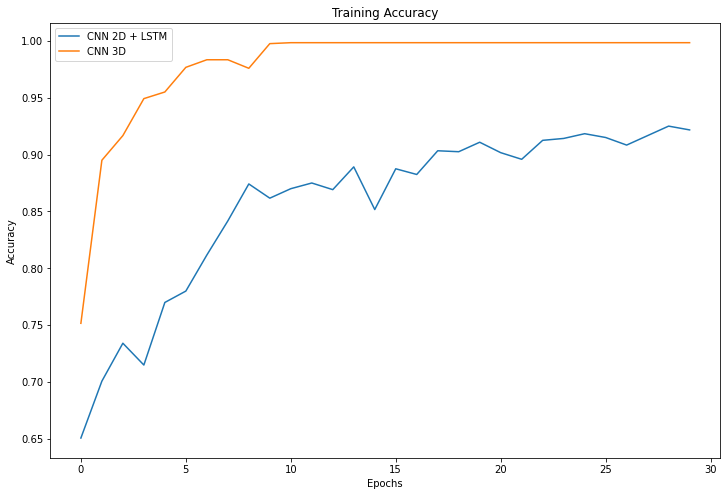

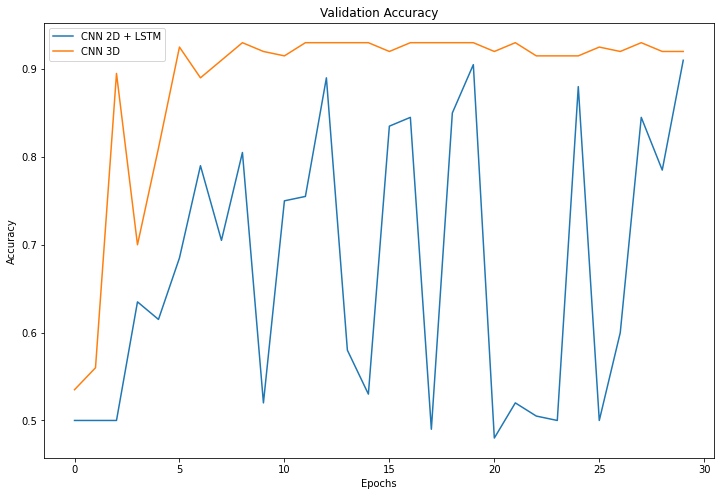

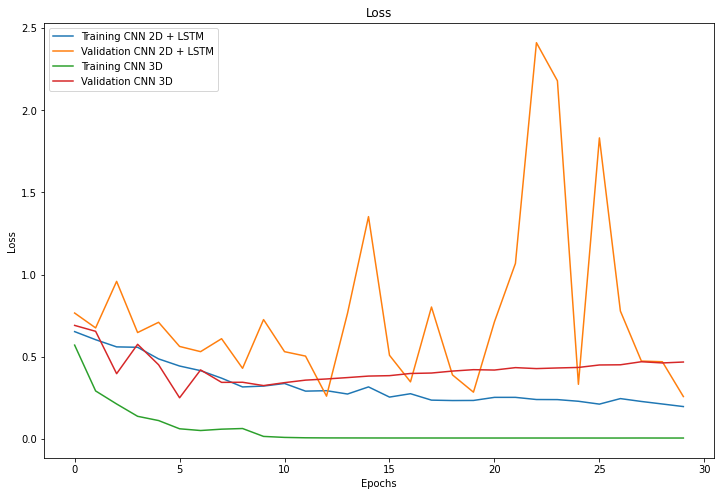

In [ ]:
cnn_lstm_acc = cnn_lstm_history.history['accuracy']
cnn_lstm_val_acc = cnn_lstm_history.history['val_accuracy']
cnn_lstm_loss = cnn_lstm_history.history['loss']
cnn_lstm_val_loss = cnn_lstm_history.history['val_loss']

cnn_three_acc = cnn_three_history.history['accuracy']
cnn_three_val_acc = cnn_three_history.history['val_accuracy']
cnn_three_loss = cnn_three_history.history['loss']
cnn_three_val_loss = cnn_three_history.history['val_loss']

plt.figure(figsize=(12,8))
plt.plot(cnn_lstm_acc,label='CNN 2D + LSTM')
plt.plot(cnn_three_acc, label = 'CNN 3D')
plt.title('Training Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.figure(figsize=(12,8))
plt.plot(cnn_lstm_val_acc, label='CNN 2D + LSTM')
plt.plot(cnn_three_val_acc, label = 'CNN 3D')
plt.title('Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


plt.figure(figsize=(12,8))
plt.plot(cnn_lstm_loss, label='Training CNN 2D + LSTM')
plt.plot(cnn_lstm_val_loss, label='Validation CNN 2D + LSTM')
plt.plot(cnn_three_loss, label = 'Training CNN 3D')
plt.plot(cnn_three_val_loss, label = 'Validation CNN 3D')
plt.title('Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

## Notes :

- 3D CNNs perform much better than CNN 2D + LSTM on both train and val sets

- Moreover, 3D CNNs are much more stable

- It can be explain by the fact that we deal with volumetric images so it seems logical to process the 3 spatial dimensions at the same time and not decorrelate them (if so, we lose the correlations between the spatial dimensions)